# Временные ряды

# 1 Работа с временным рядом, форматирование, визуализация

![](https://mlcourse.ai/images/topic4-teaser.png)

Временной ряд — собранный в разные моменты времени статистический материал о значении каких-либо параметров исследуемого процесса.

Временным рядом
$$\{x_i\}_{i=1}^N$$
называется массив из $N$ чисел, представляющих собой значения некоторой измеренной (наблюдаемой динамической переменной $x(t)$ с некоторым постоянным шагом $τ$ по времени.

 Примеры:
- объёмы продаж в торговых сетях
- объёмы потребления и цены электроэнергии
- остатки складских запасов
- рыночные цены (акции)
- дорожный трафик (прогнозирование пробок)
- инфляция

Основные свойства временных рядов:
- тренды
- сезонности

Какие задачи здесь возникают?

Для начала визуализируем наши данные и попробуем сформулировать новые гипотезы о задаче, которую хотим решить.

Загрузим данные и посмотрим на структуру данных

## Чтение данных

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

pd.options.display.float_format = "{:.2f}".format

# данные по продажам в Индии в различных городах и штатах
df = pd.read_csv("MarketArrivals_Ind.csv")

## Анализ структуры данных

In [ ]:
df.shape

(10227, 10)

In [ ]:
df.head()

market    month  year  quantity  priceMin  priceMax  priceMod state  \
0  ABOHAR(PB)  January  2005      2350       404       493       446    PB   
1  ABOHAR(PB)  January  2006       900       487       638       563    PB   
2  ABOHAR(PB)  January  2010       790      1283      1592      1460    PB   
3  ABOHAR(PB)  January  2011       245      3067      3750      3433    PB   
4  ABOHAR(PB)  January  2012      1035       523       686       605    PB   

     city          date  
0  ABOHAR  January-2005  
1  ABOHAR  January-2006  
2  ABOHAR  January-2010  
3  ABOHAR  January-2011  
4  ABOHAR  January-2012


В нашем датафрейме 10 столбцов.

В датафрейме следующие типы данных:
- **CATEGORICAL**: state, city, market
- **TIME INTERVAL**: month, year, date
- **QUANTITATIVE**: quantity, priceMin, priceMax, priceModal

Посмотрим какие типы данных pandas определил при чтении данных.

In [ ]:
# Выведем типы данных
df.dtypes

market      object
month       object
year         int64
quantity     int64
priceMin     int64
priceMax     int64
priceMod     int64
state       object
city        object
date        object
dtype: object

Видим, что количественные столбцы отображаться как целочисленные и категориальные как объекты(строки), что отлично.
Однако, столбцы `date` прочитаны как объект, а не даты(время). Исправим это.

In [ ]:
df.date = pd.DatetimeIndex(df.date)

In [ ]:
df.shape

(10227, 10)

In [ ]:
df.dtypes

market              object
month               object
year                 int64
quantity             int64
priceMin             int64
priceMax             int64
priceMod             int64
state               object
city                object
date        datetime64[ns]
dtype: object

In [ ]:
df.head()

market    month  year  quantity  priceMin  priceMax  priceMod state  \
0  ABOHAR(PB)  January  2005      2350       404       493       446    PB   
1  ABOHAR(PB)  January  2006       900       487       638       563    PB   
2  ABOHAR(PB)  January  2010       790      1283      1592      1460    PB   
3  ABOHAR(PB)  January  2011       245      3067      3750      3433    PB   
4  ABOHAR(PB)  January  2012      1035       523       686       605    PB   

     city       date  
0  ABOHAR 2005-01-01  
1  ABOHAR 2006-01-01  
2  ABOHAR 2010-01-01  
3  ABOHAR 2011-01-01  
4  ABOHAR 2012-01-01

## Насколько большой был рынок в Бангалоре по сравнению с другими городами в 2010 году?

Ответим на этот вопрос, используя данные 2010го года.

In [ ]:
df2010 = df[df.year == 2010]

In [ ]:
df2010.head()

market     month  year  quantity  priceMin  priceMax  priceMod state  \
2   ABOHAR(PB)   January  2010       790      1283      1592      1460    PB   
10  ABOHAR(PB)  February  2010       555      1143      1460      1322    PB   
18  ABOHAR(PB)     March  2010       385       510       878       688    PB   
25  ABOHAR(PB)     April  2010       840       466       755       611    PB   
32  ABOHAR(PB)       May  2010      2050       391       578       494    PB   

      city       date  
2   ABOHAR 2010-01-01  
10  ABOHAR 2010-02-01  
18  ABOHAR 2010-03-01  
25  ABOHAR 2010-04-01  
32  ABOHAR 2010-05-01

In [ ]:
df2010Bang = df[(df.year == 2010) & (df.city == "BANGALORE")]

In [ ]:
df2010Bang.head()

market     month  year  quantity  priceMin  priceMax  priceMod state  \
722  BANGALORE   January  2010    423649       502      1837      1267   KNT   
735  BANGALORE  February  2010    316685       495      1429      1011   KNT   
748  BANGALORE     March  2010    368644       386       895       661   KNT   
760  BANGALORE     April  2010    404805       287       730       545   KNT   
772  BANGALORE       May  2010    395519       306       827       564   KNT   

          city       date  
722  BANGALORE 2010-01-01  
735  BANGALORE 2010-02-01  
748  BANGALORE 2010-03-01  
760  BANGALORE 2010-04-01  
772  BANGALORE 2010-05-01

In [ ]:
# Считаем суммы по quantity
df2010City = df2010.groupby(["city"]).quantity.sum()

In [ ]:
df2010City.head()

city
ABOHAR          11835
AGRA           756755
AHMEDABAD     1135418
AHMEDNAGAR    1678032
ALWAR          561145
Name: quantity, dtype: int64

In [ ]:
type(df2010City)

pandas.core.series.Series

In [ ]:
# Создаем dataframe
df2010City = df2010.groupby(["city"], as_index=False).quantity.sum()

In [ ]:
df2010City.head()

city  quantity
0      ABOHAR     11835
1        AGRA    756755
2   AHMEDABAD   1135418
3  AHMEDNAGAR   1678032
4       ALWAR    561145

In [ ]:
# Cортируем df по Quantity
df2010City = df2010City.sort_values(by="quantity", ascending=False)
df2010City.head()

city  quantity
6   BANGALORE   6079067
16      DELHI   3508582
39    KOLKATA   3495320
56       PUNE   3326024
67    SOLAPUR   3310419

### Выясним, какая сортировка работает быстрее

In [ ]:
%timeit df2010City.quantity.sort_values()

114 µs ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit df2010City.sort_values(by = "quantity", ascending = False)

165 µs ± 49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit sorted(df2010City.quantity)

17 µs ± 4.07 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Визуализируем наши выводы

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

<Axes: ylabel='city'>

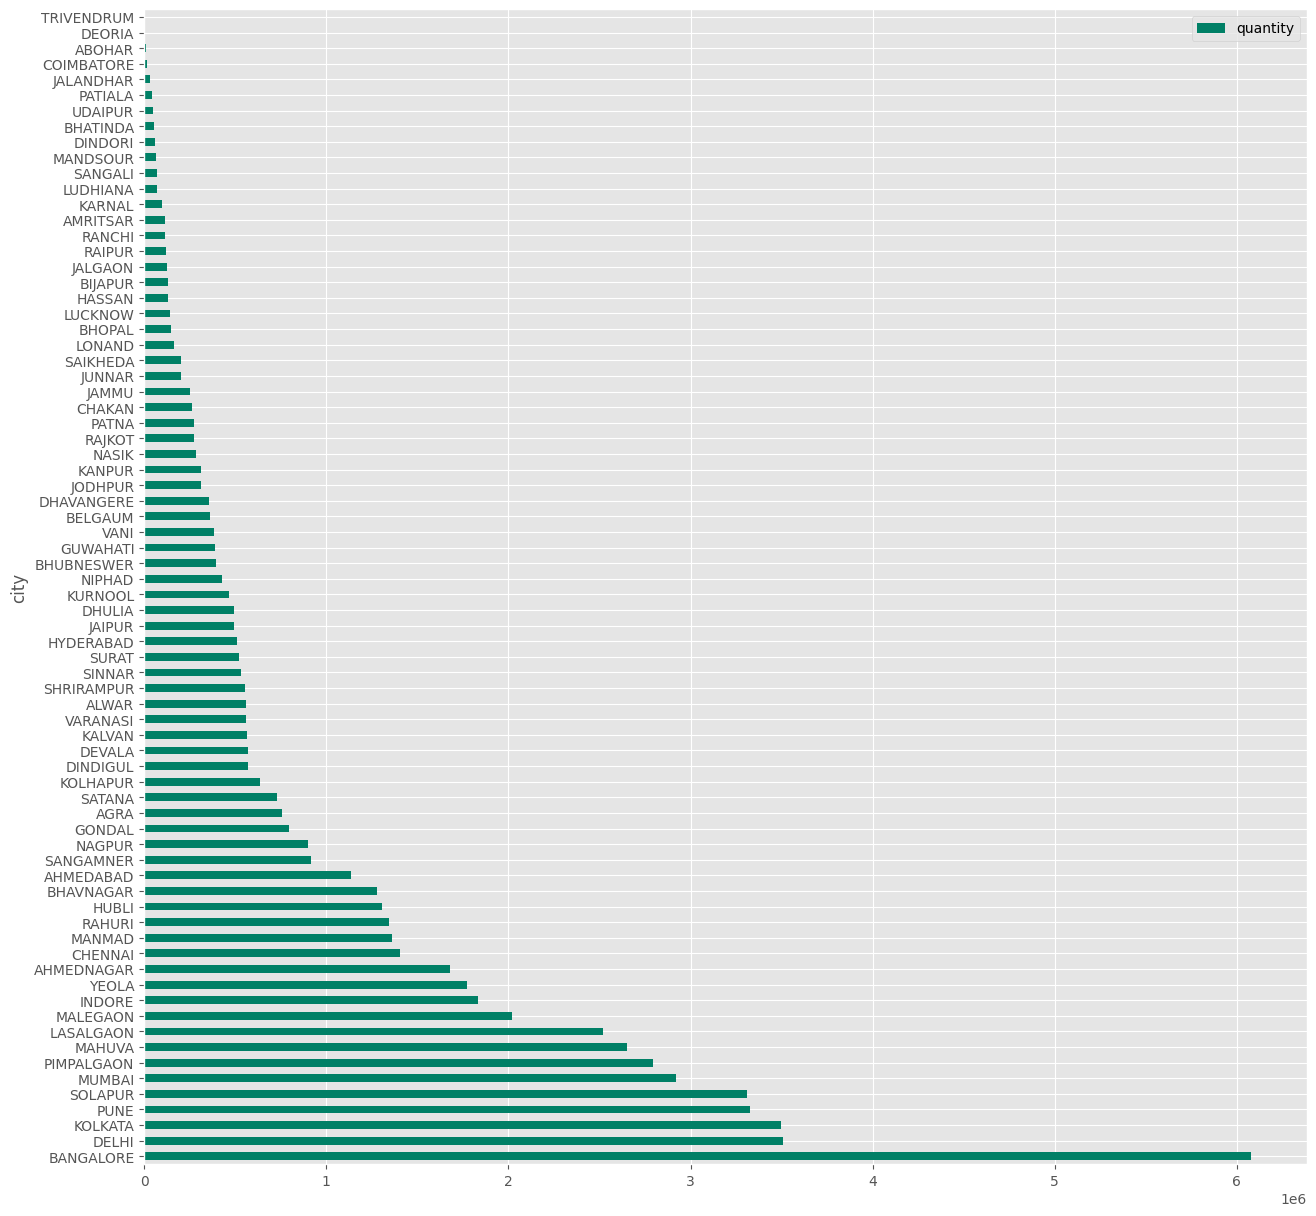

In [ ]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)
df2010City.plot(kind="barh", x="city", y="quantity", colormap="summer")

### ! Задание 1. Найти штат с наибольшими продажами в 2015 году

In [1]:
### your code here


### ! Задание 2. Вывести график кол-ва продаж в штате MS по всем городам в 2015 году

In [ ]:
### your code here


### Растет ли разброс цен в Бангалоре с годами?

In [ ]:
df.head()

market    month  year  quantity  priceMin  priceMax  priceMod state  \
0  ABOHAR(PB)  January  2005      2350       404       493       446    PB   
1  ABOHAR(PB)  January  2006       900       487       638       563    PB   
2  ABOHAR(PB)  January  2010       790      1283      1592      1460    PB   
3  ABOHAR(PB)  January  2011       245      3067      3750      3433    PB   
4  ABOHAR(PB)  January  2012      1035       523       686       605    PB   

     city       date  
0  ABOHAR 2005-01-01  
1  ABOHAR 2006-01-01  
2  ABOHAR 2010-01-01  
3  ABOHAR 2011-01-01  
4  ABOHAR 2012-01-01

In [ ]:
dfBang = df[df.city == "BANGALORE"]

In [ ]:
dfBang.head()

market    month  year  quantity  priceMin  priceMax  priceMod state  \
716  BANGALORE  January  2004    227832       916      1066       991   KNT   
717  BANGALORE  January  2005    335679       470       597       522   KNT   
718  BANGALORE  January  2006    412185       286       617       537   KNT   
719  BANGALORE  January  2007    268268       586      1167       942   KNT   
720  BANGALORE  January  2008    393806       174       671       472   KNT   

          city       date  
716  BANGALORE 2004-01-01  
717  BANGALORE 2005-01-01  
718  BANGALORE 2006-01-01  
719  BANGALORE 2007-01-01  
720  BANGALORE 2008-01-01

In [ ]:
dfBang.describe()

year   quantity  priceMin  priceMax  priceMod  \
count  146.00     146.00    146.00    146.00    146.00   
mean  2009.59  523917.42    557.54   1313.88   1043.55   
min   2004.00   63824.00    145.00    338.00    320.00   
25%   2007.00  329690.00    307.00    685.00    551.00   
50%   2010.00  403530.50    448.00   1019.00    836.00   
75%   2013.00  661252.00    653.00   1636.00   1325.50   
max   2016.00 1639032.00   2377.00   4698.00   3430.00   
std      3.52  302369.03    381.42    911.10    667.51   

                                date  
count                            146  
mean   2010-01-15 09:41:55.068493056  
min              2004-01-01 00:00:00  
25%              2007-01-08 18:00:00  
50%              2010-01-16 12:00:00  
75%              2013-01-24 06:00:00  
max              2016-02-01 00:00:00  
std                              NaN

Установим Index как date.

In [ ]:
dfBang.head()

market    month  year  quantity  priceMin  priceMax  priceMod state  \
716  BANGALORE  January  2004    227832       916      1066       991   KNT   
717  BANGALORE  January  2005    335679       470       597       522   KNT   
718  BANGALORE  January  2006    412185       286       617       537   KNT   
719  BANGALORE  January  2007    268268       586      1167       942   KNT   
720  BANGALORE  January  2008    393806       174       671       472   KNT   

          city       date  
716  BANGALORE 2004-01-01  
717  BANGALORE 2005-01-01  
718  BANGALORE 2006-01-01  
719  BANGALORE 2007-01-01  
720  BANGALORE 2008-01-01

In [ ]:
dfBang.index

Index([716, 717, 718, 719, 720, 721, 722, 723, 724, 725,
       ...
       852, 853, 854, 855, 856, 857, 858, 859, 860, 861],
      dtype='int64', length=146)

In [ ]:
# Упорядочим по датам
dfBang = dfBang.sort_values(by="date")
dfBang.head()

market     month  year  quantity  priceMin  priceMax  priceMod state  \
716  BANGALORE   January  2004    227832       916      1066       991   KNT   
729  BANGALORE  February  2004    225133       741       870       793   KNT   
742  BANGALORE     March  2004    221952       527       586       556   KNT   
754  BANGALORE     April  2004    185150       419       518       465   KNT   
766  BANGALORE       May  2004    137390       400       516       455   KNT   

          city       date  
716  BANGALORE 2004-01-01  
729  BANGALORE 2004-02-01  
742  BANGALORE 2004-03-01  
754  BANGALORE 2004-04-01  
766  BANGALORE 2004-05-01

In [ ]:
# Установим index
dfBang.index = pd.PeriodIndex(dfBang.date, freq="M")

In [ ]:
dfBang.head()

market     month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                         
2004-01  BANGALORE   January  2004    227832       916      1066       991   
2004-02  BANGALORE  February  2004    225133       741       870       793   
2004-03  BANGALORE     March  2004    221952       527       586       556   
2004-04  BANGALORE     April  2004    185150       419       518       465   
2004-05  BANGALORE       May  2004    137390       400       516       455   

        state       city       date  
date                                 
2004-01   KNT  BANGALORE 2004-01-01  
2004-02   KNT  BANGALORE 2004-02-01  
2004-03   KNT  BANGALORE 2004-03-01  
2004-04   KNT  BANGALORE 2004-04-01  
2004-05   KNT  BANGALORE 2004-05-01

Нарисуем график величины priceMod

<Axes: xlabel='date'>

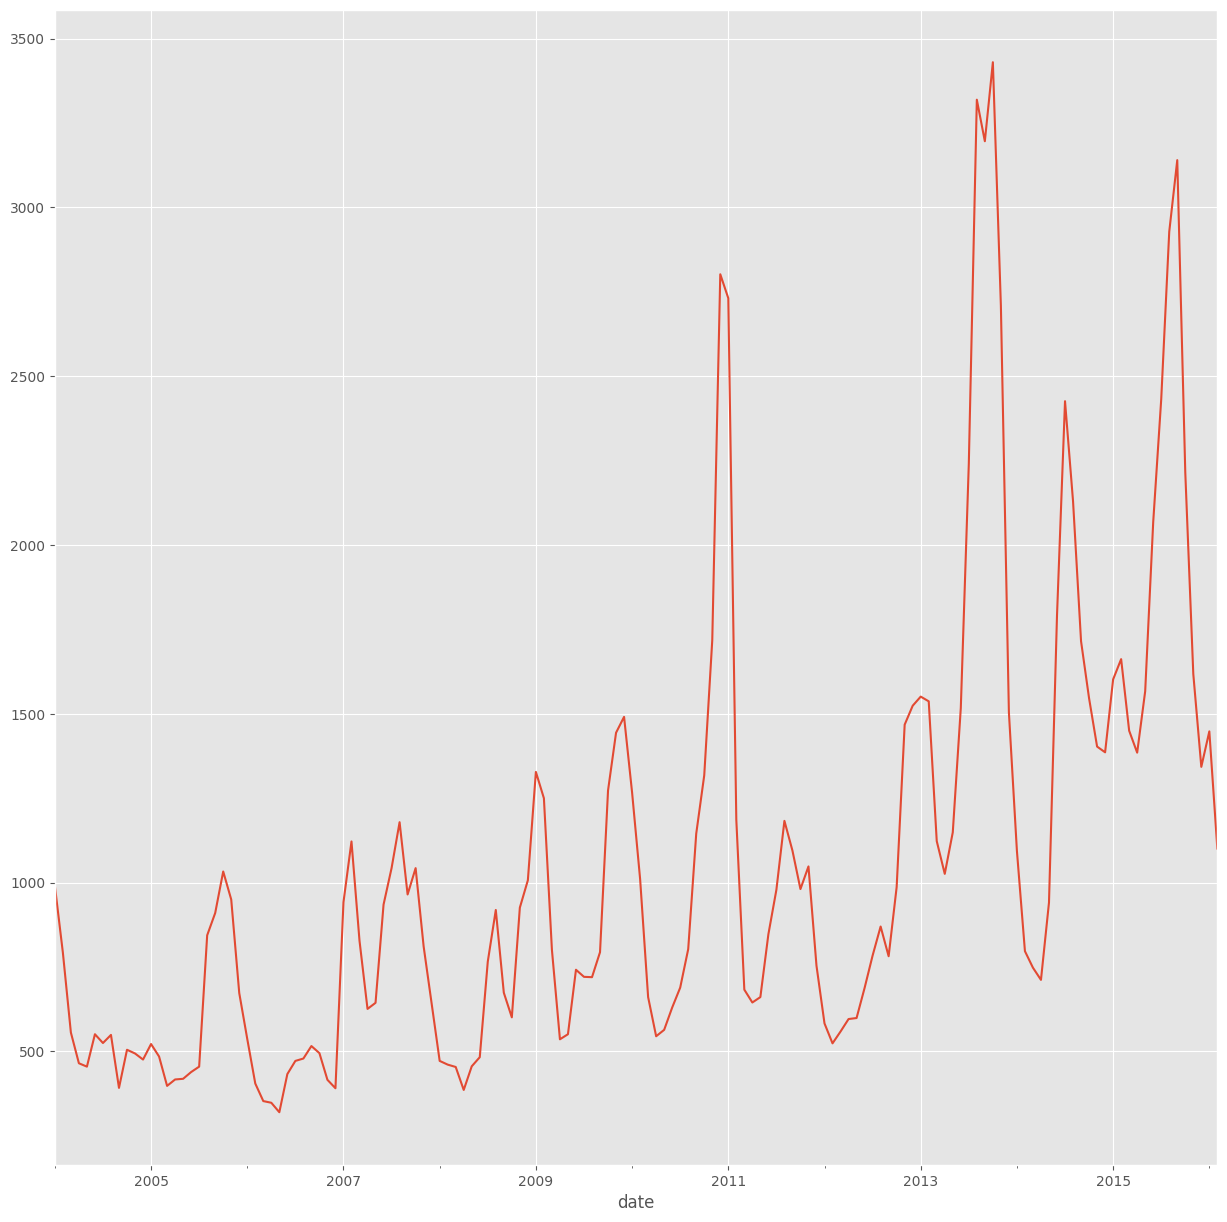

In [ ]:
dfBang.priceMod.plot()

<Axes: xlabel='date'>

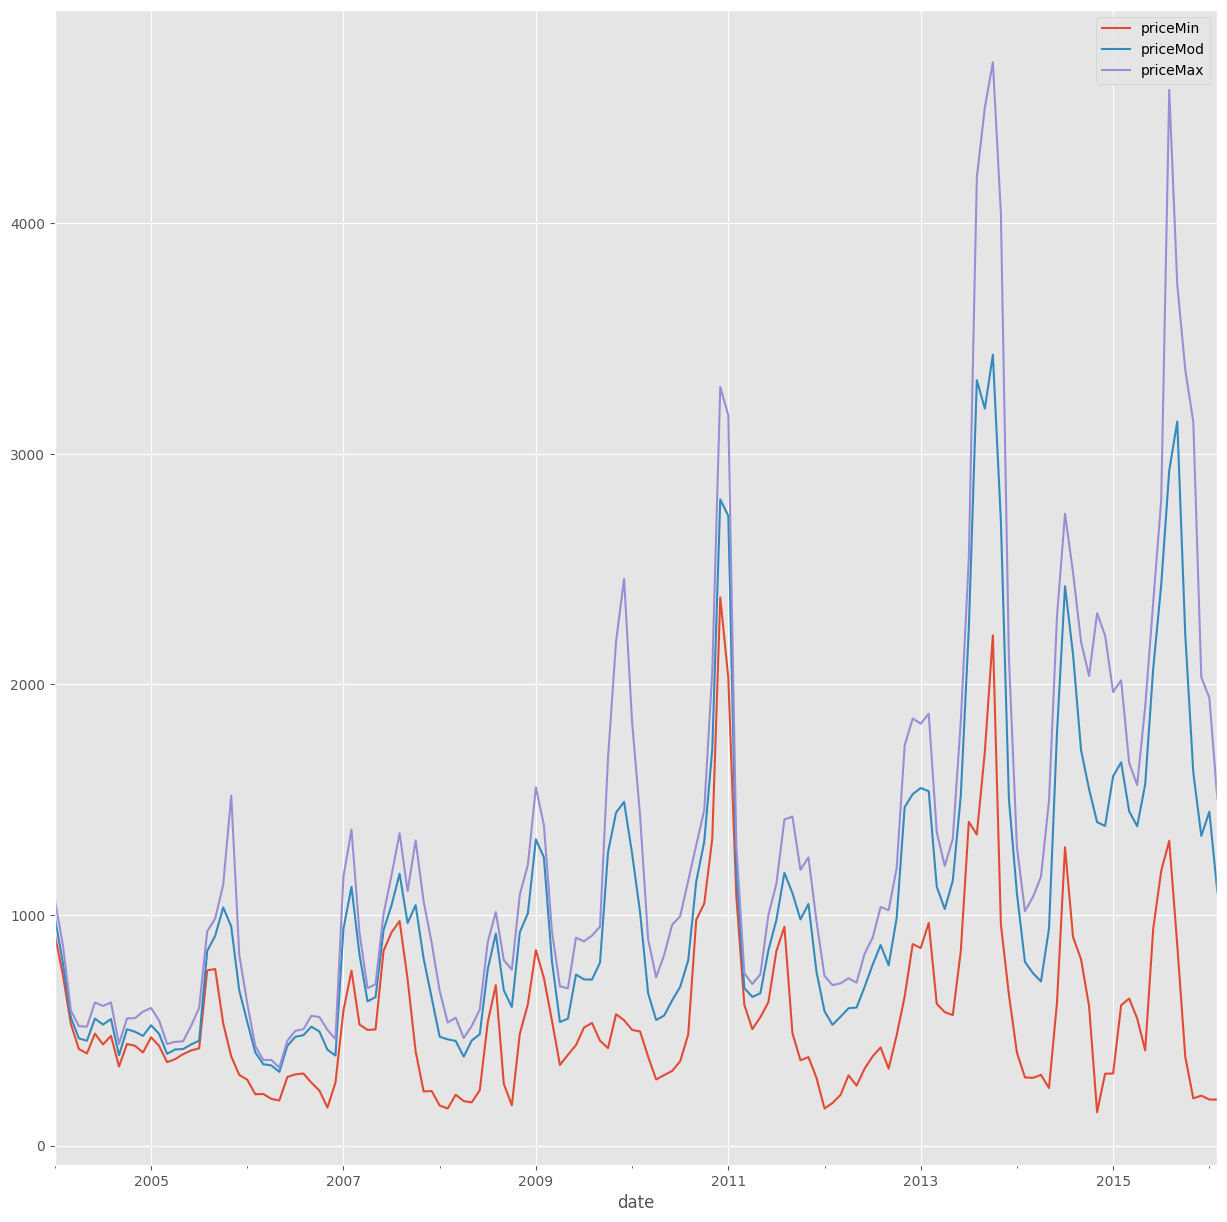

In [ ]:
dfBang.plot(kind="line", y=["priceMin", "priceMod", "priceMax"])

Для расчета изменения создадим новый атрибут с разницей priceMax и priceMin  

In [ ]:
dfBang["priceDiff"] = dfBang["priceMax"] - dfBang["priceMin"]

In [ ]:
dfBang.head()

market     month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                         
2004-01  BANGALORE   January  2004    227832       916      1066       991   
2004-02  BANGALORE  February  2004    225133       741       870       793   
2004-03  BANGALORE     March  2004    221952       527       586       556   
2004-04  BANGALORE     April  2004    185150       419       518       465   
2004-05  BANGALORE       May  2004    137390       400       516       455   

        state       city       date  priceDiff  
date                                            
2004-01   KNT  BANGALORE 2004-01-01        150  
2004-02   KNT  BANGALORE 2004-02-01        129  
2004-03   KNT  BANGALORE 2004-03-01         59  
2004-04   KNT  BANGALORE 2004-04-01         99  
2004-05   KNT  BANGALORE 2004-05-01        116

Выведем график priceDiff

<Axes: xlabel='date'>

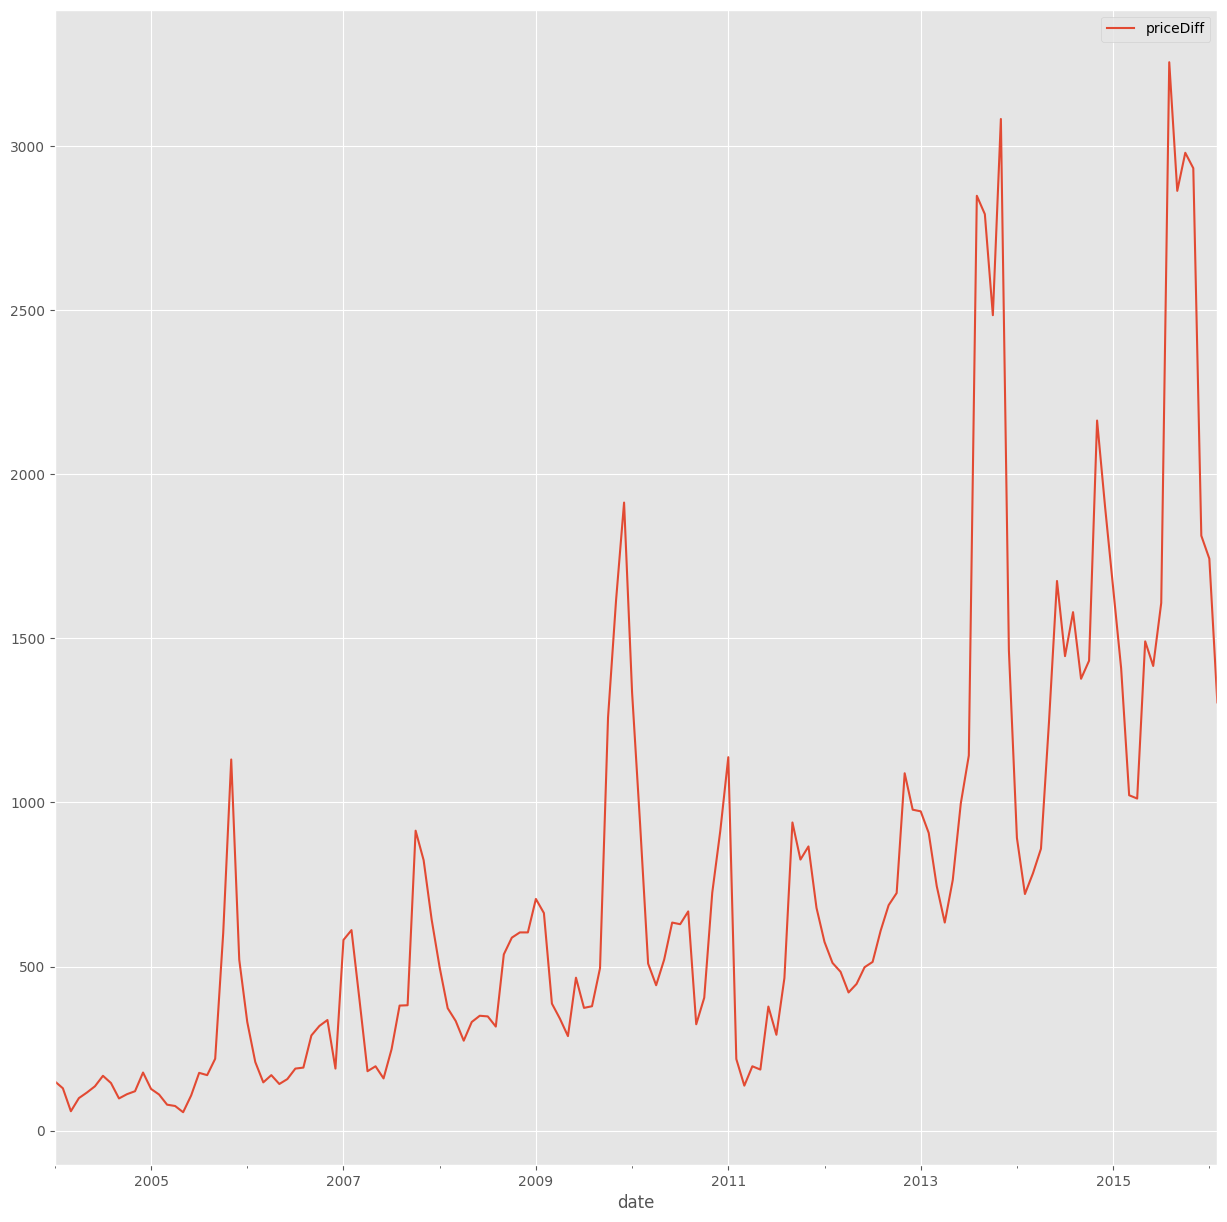

In [ ]:
dfBang.plot(kind="line", y="priceDiff")

### Сводные таблицы (pivot table)

Возможность создавать сводные таблицы присутствует в электронных таблицах и других программах, оперирующих табличными данными.  
Сводная таблица принимает на входе данные из отдельных столбцов и группирует их, формируя двумерную таблицу, реализующую многомерное обобщение данных.  
Чтобы ощутить разницу между сводной таблицей и операцией GroupBy, можно представить себе сводную таблицу, как многомерный вариант агрегации посредством GroupBy. То есть данные разделяются, преобразуются и объединяются, но при этом разделение и объединение осуществляются не по одномерному индексу, а по двумерной сетке.
![](https://pandas.pydata.org/pandas-docs/stable/_images/reshaping_pivot.png)


In [ ]:
# Создадим новый столбец для значения Месяц
dfBang["monthVal"] = pd.DatetimeIndex(dfBang["date"]).month

In [ ]:
dfBang.head()

market     month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                         
2004-01  BANGALORE   January  2004    227832       916      1066       991   
2004-02  BANGALORE  February  2004    225133       741       870       793   
2004-03  BANGALORE     March  2004    221952       527       586       556   
2004-04  BANGALORE     April  2004    185150       419       518       465   
2004-05  BANGALORE       May  2004    137390       400       516       455   

        state       city       date  priceDiff  monthVal  
date                                                      
2004-01   KNT  BANGALORE 2004-01-01        150         1  
2004-02   KNT  BANGALORE 2004-02-01        129         2  
2004-03   KNT  BANGALORE 2004-03-01         59         3  
2004-04   KNT  BANGALORE 2004-04-01         99         4  
2004-05   KNT  BANGALORE 2004-05-01        116         5

Cоздадим сводную таблицу по priceDiff (строки - monthval, столбцы - year)

In [ ]:
dfBangPivot = pd.pivot_table(
    dfBang, values="priceDiff", columns="year", index="monthVal"
)

In [ ]:
dfBangPivot

year       2004    2005   2006   2007   2008    2009    2010    2011    2012  \
monthVal                                                                       
1        150.00  127.00 331.00 581.00 497.00  706.00 1335.00 1138.00  575.00   
2        129.00  110.00 209.00 611.00 373.00  663.00  934.00  218.00  511.00   
3         59.00   79.00 147.00 398.00 334.00  387.00  509.00  137.00  484.00   
4         99.00   75.00 169.00 181.00 274.00  341.00  443.00  196.00  421.00   
5        116.00   56.00 142.00 196.00 331.00  288.00  521.00  186.00  447.00   
6        135.00  107.00 157.00 159.00 350.00  466.00  634.00  378.00  498.00   
7        167.00  176.00 189.00 248.00 348.00  374.00  629.00  292.00  514.00   
8        145.00  169.00 192.00 381.00 317.00  379.00  668.00  465.00  609.00   
9         98.00  219.00 290.00 382.00 537.00  495.00  324.00  939.00  687.00   
10       111.00  602.00 319.00 914.00 588.00 1259.00  405.00  826.00  724.00   
11       120.00 1131.00 337.00 824.00 604.00 1616.00  725.00  866.00 1089.00   
12       177.00  521.00 189.00 643.00 604.00 1914.00  913.00  679.00  978.00   

year        2013    2014    2015    2016  
monthVal                                  
1         973.00  892.00 1654.00 1743.00  
2         907.00  721.00 1409.00 1305.00  
3         745.00  784.00 1022.00     NaN  
4         634.00  859.00 1012.00     NaN  
5         764.00 1245.00 1491.00     NaN  
6         997.00 1675.00 1416.00     NaN  
7        1143.00 1446.00 1608.00     NaN  
8        2849.00 1580.00 3256.00     NaN  
9        2793.00 1377.00 2864.00     NaN  
10       2485.00 1432.00 2980.00     NaN  
11       3083.00 2164.00 2933.00     NaN  
12       1463.00 1900.00 1813.00     NaN

<Axes: xlabel='monthVal'>

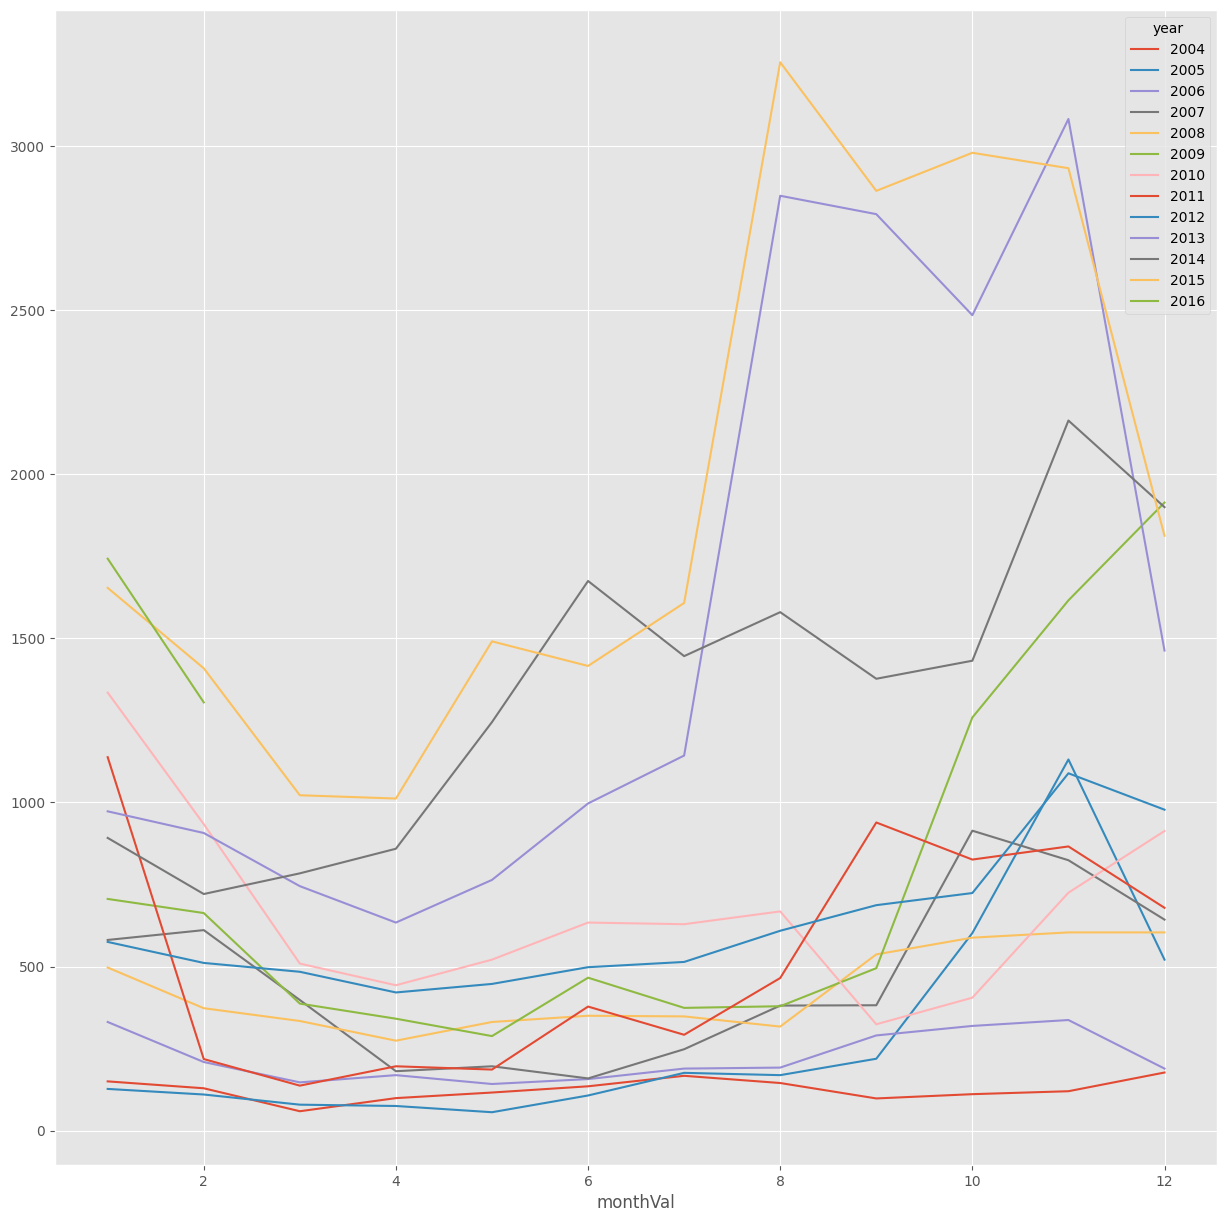

In [ ]:
plt.style.use("ggplot")
dfBangPivot.plot()

### ! Задание 3. Вывести сводную таблицу с quantity по штатам и годам

In [2]:
### your code here


# 2 Прогнозирование временного ряда

### Подготовка данных

In [ ]:
# Отсортируем и добавим date в индекс
df.index = pd.PeriodIndex(df.date, freq="M")
df = df.rename(columns={'date':'date_time'})
df = df.sort_values(by='date_time')

In [ ]:
df.head()

market     month  year  quantity  priceMin  priceMax  \
date                                                                   
1996-01  LASALGAON(MS)   January  1996    225063       160       257   
1996-02  LASALGAON(MS)  February  1996    196164       133       229   
1996-03  LASALGAON(MS)     March  1996    178992       155       274   
1996-04  LASALGAON(MS)     April  1996    192592       136       279   
1996-05  LASALGAON(MS)       May  1996    237574       154       312   

         priceMod state       city  date_time  
date                                           
1996-01       226    MS  LASALGAON 1996-01-01  
1996-02       186    MS  LASALGAON 1996-02-01  
1996-03       243    MS  LASALGAON 1996-03-01  
1996-04       254    MS  LASALGAON 1996-04-01  
1996-05       269    MS  LASALGAON 1996-05-01

Будем работать с данными в городе Бангалор

In [ ]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

In [ ]:
dfBang.head()

market     month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                         
2004-01  BANGALORE   January  2004    227832       916      1066       991   
2004-02  BANGALORE  February  2004    225133       741       870       793   
2004-03  BANGALORE     March  2004    221952       527       586       556   
2004-04  BANGALORE     April  2004    185150       419       518       465   
2004-05  BANGALORE       May  2004    137390       400       516       455   

        state       city  date_time  
date                                 
2004-01   KNT  BANGALORE 2004-01-01  
2004-02   KNT  BANGALORE 2004-02-01  
2004-03   KNT  BANGALORE 2004-03-01  
2004-04   KNT  BANGALORE 2004-04-01  
2004-05   KNT  BANGALORE 2004-05-01

In [ ]:
# Удалим лишние столбцы
dfBang = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax"], axis=1
)

In [ ]:
dfBang.head()

quantity  priceMod  date_time
date                                  
2004-01    227832       991 2004-01-01
2004-02    225133       793 2004-02-01
2004-03    221952       556 2004-03-01
2004-04    185150       465 2004-04-01
2004-05    137390       455 2004-05-01

<Axes: xlabel='date'>

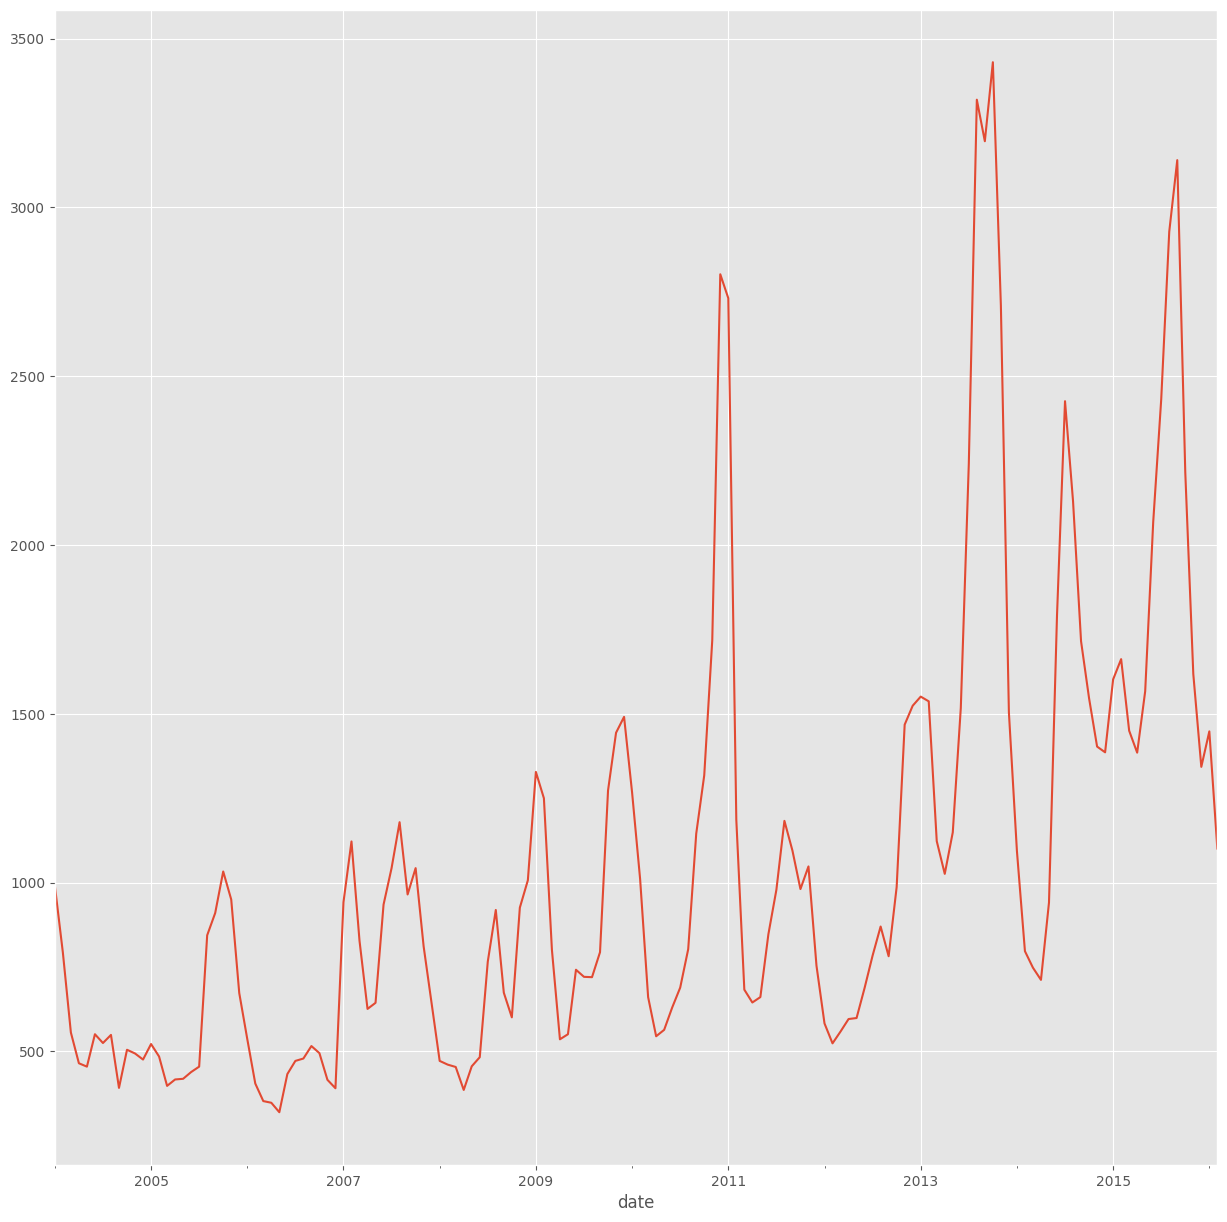

In [ ]:
dfBang.priceMod.plot()

<Axes: xlabel='date'>

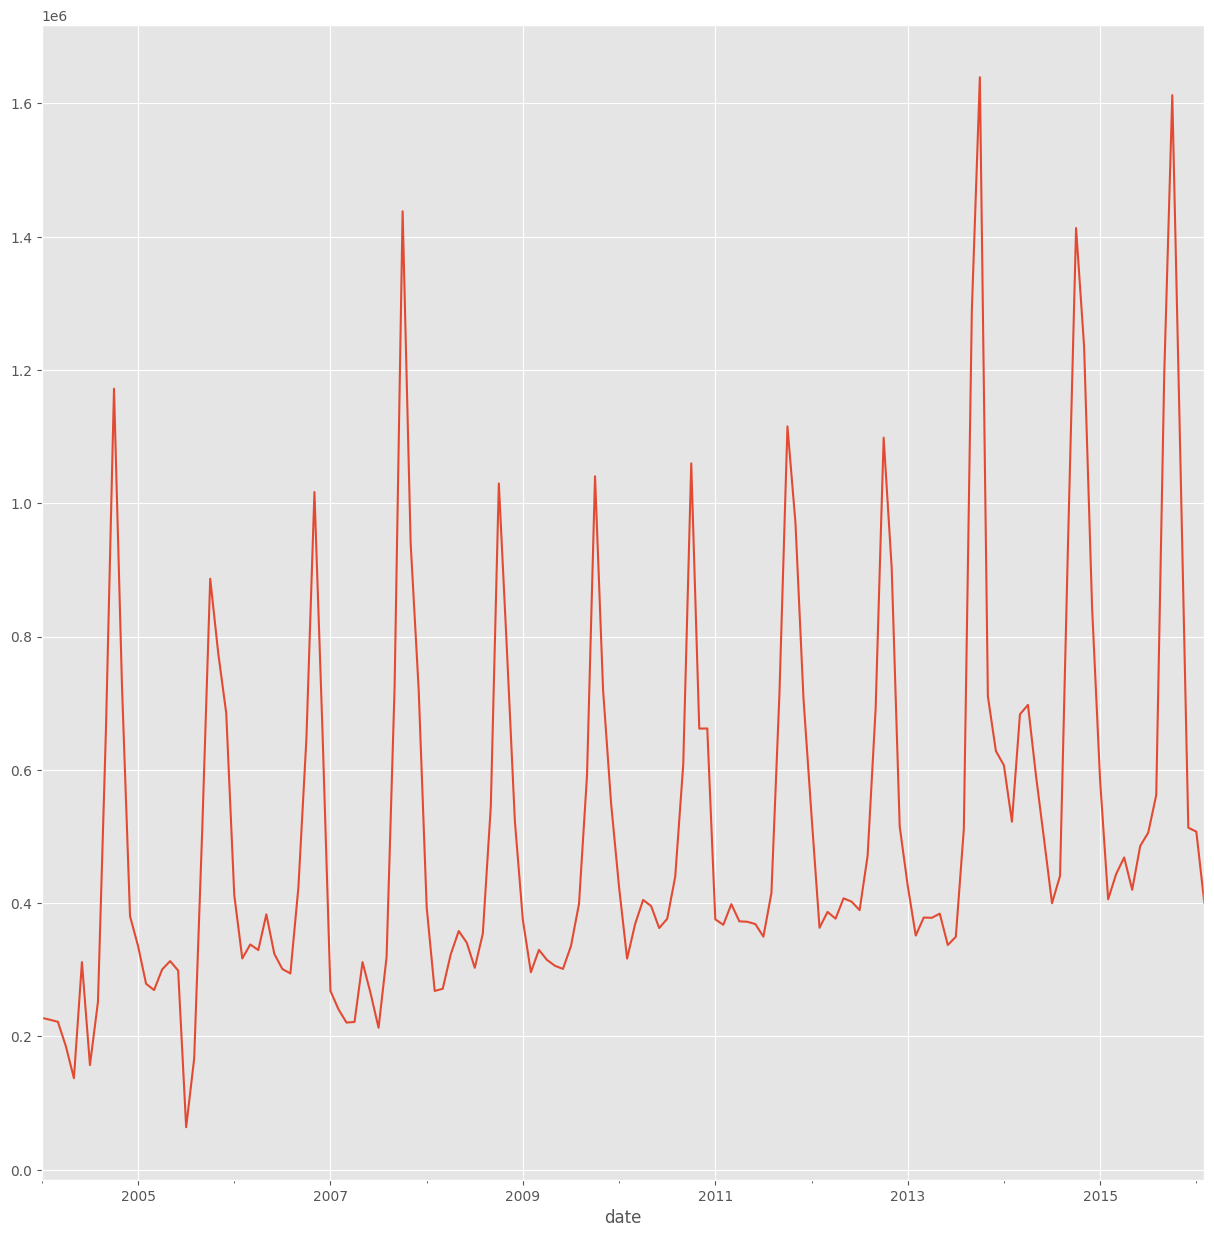

In [ ]:
dfBang.quantity.plot()

Начнем с трех простых моделей прогноза цены

1. Прогнозирование средним (Mean Constant Model)
2. Линейная модель (Linear Trend Model)
3. Модель со случайными изменениями (Random Walk Model)

### Логарифмическое преобразование данных
Логарифмирование помогает стабилизировать разброс значений.

<Axes: ylabel='Frequency'>

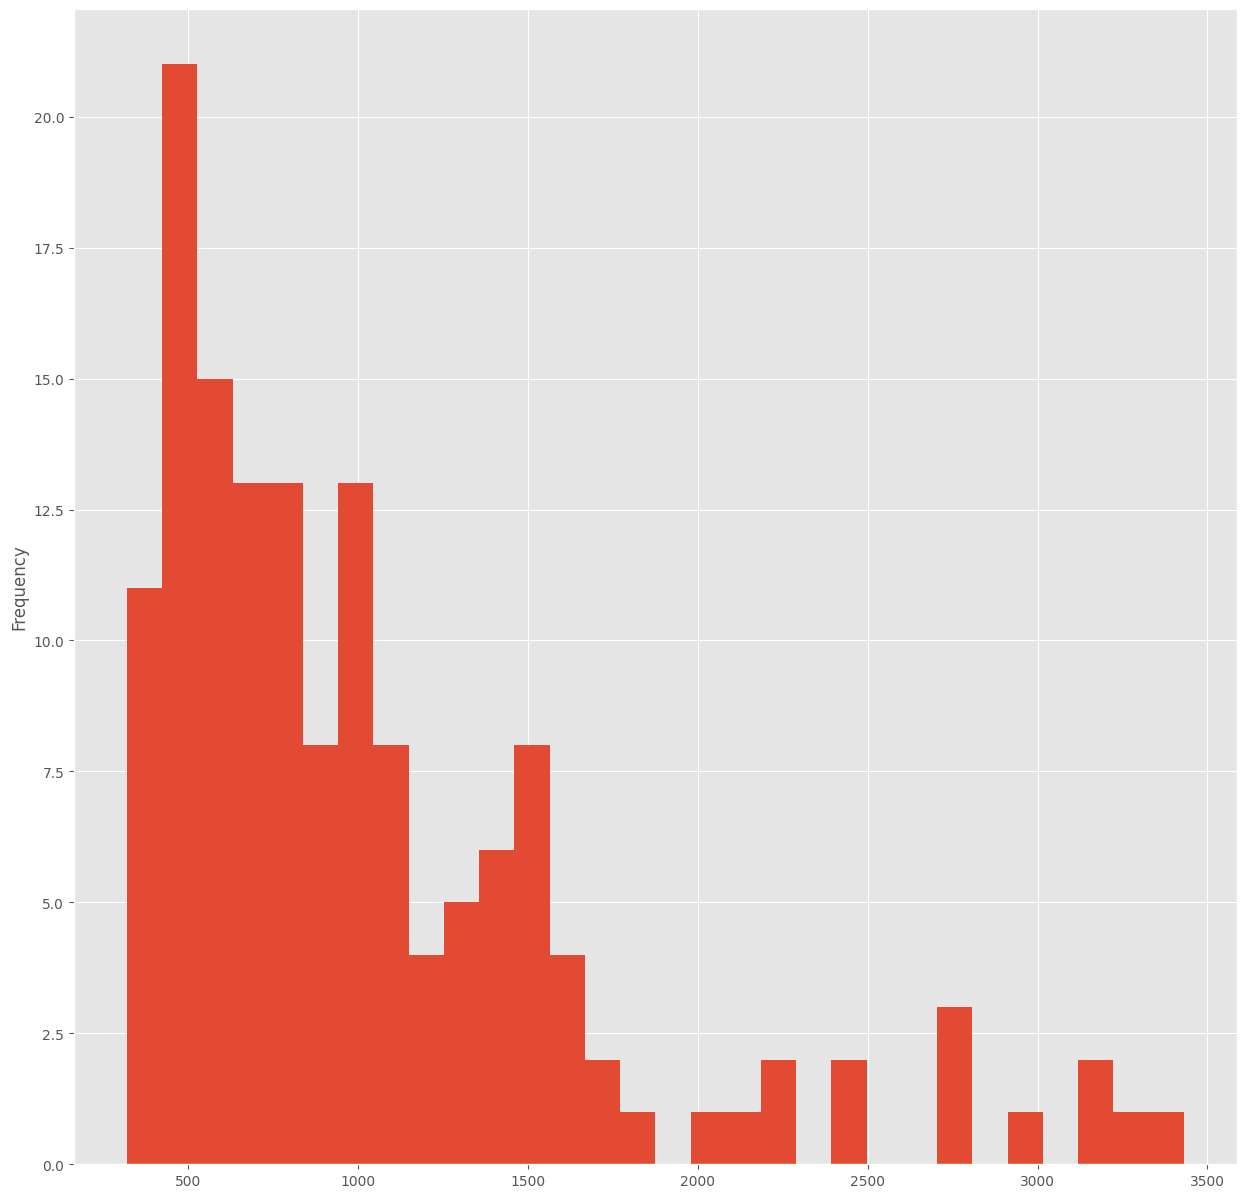

In [ ]:
dfBang.priceMod.plot(kind="hist", bins=30)

При визуализации можем заметить, что есть данные, далеко отстающие от среднего значения, что может искажать модель регрессии. Наша задача минимизировать влияние таких данных. Желательно не исключая их.  
В этом случае самый распространенный вариант действия - логарифмирование переменной.

In [ ]:
dfBang["priceModLog"] = np.log(dfBang.priceMod)
dfBang.head()

quantity  priceMod  date_time  priceModLog
date                                               
2004-01    227832       991 2004-01-01         6.90
2004-02    225133       793 2004-02-01         6.68
2004-03    221952       556 2004-03-01         6.32
2004-04    185150       465 2004-04-01         6.14
2004-05    137390       455 2004-05-01         6.12

<Axes: ylabel='Frequency'>

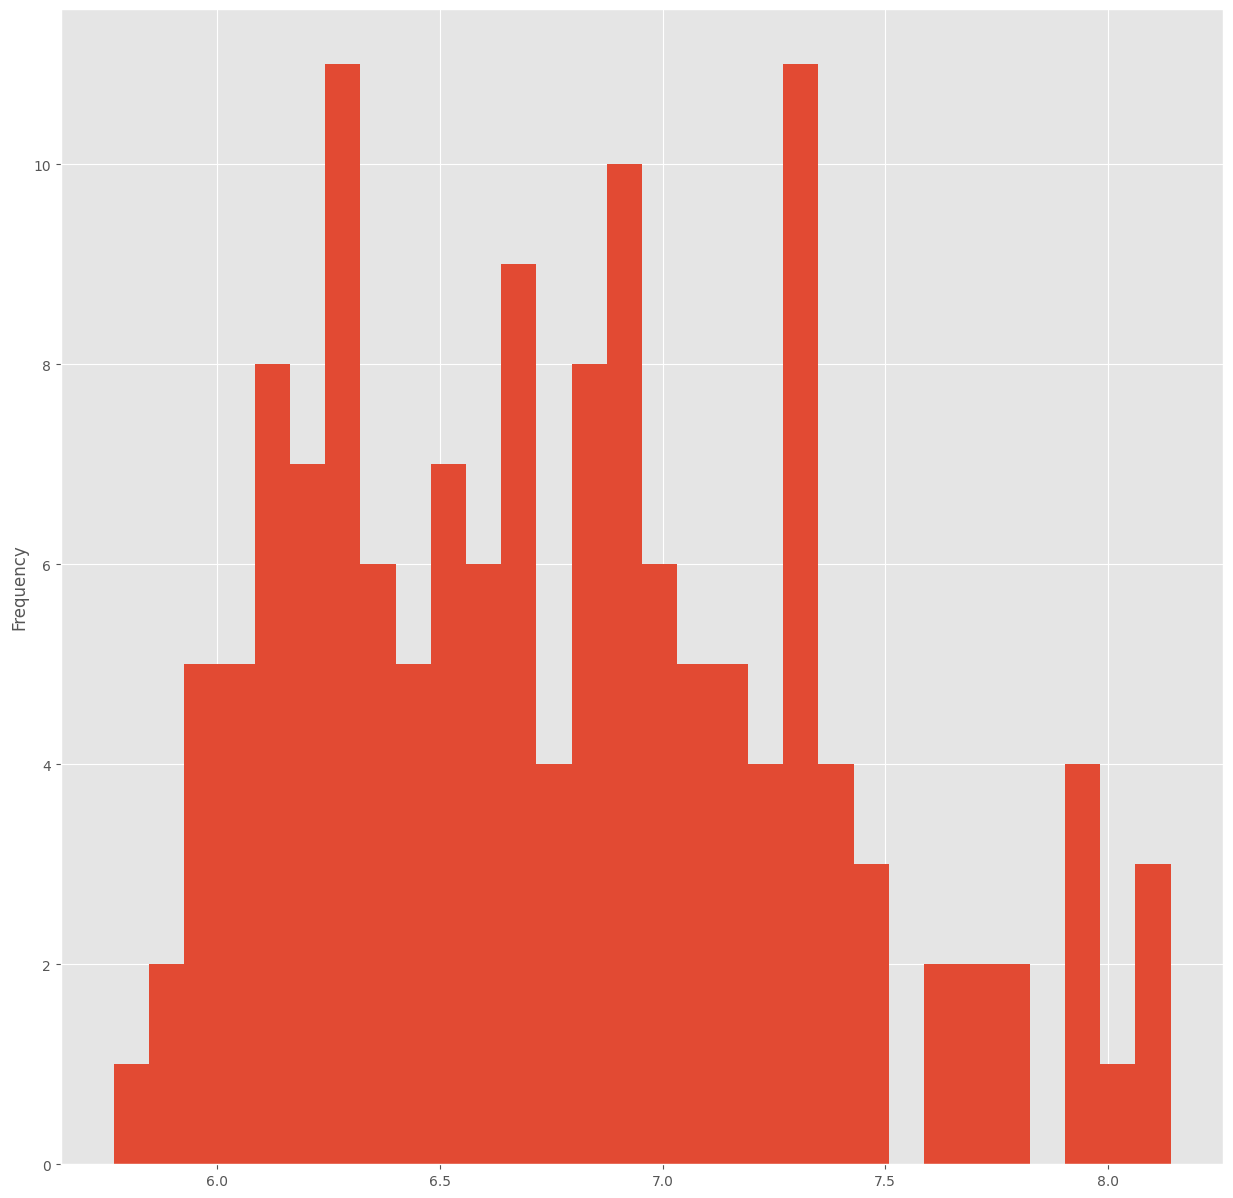

In [ ]:
dfBang.priceModLog.plot(kind="hist", bins=30)

<Axes: xlabel='date'>

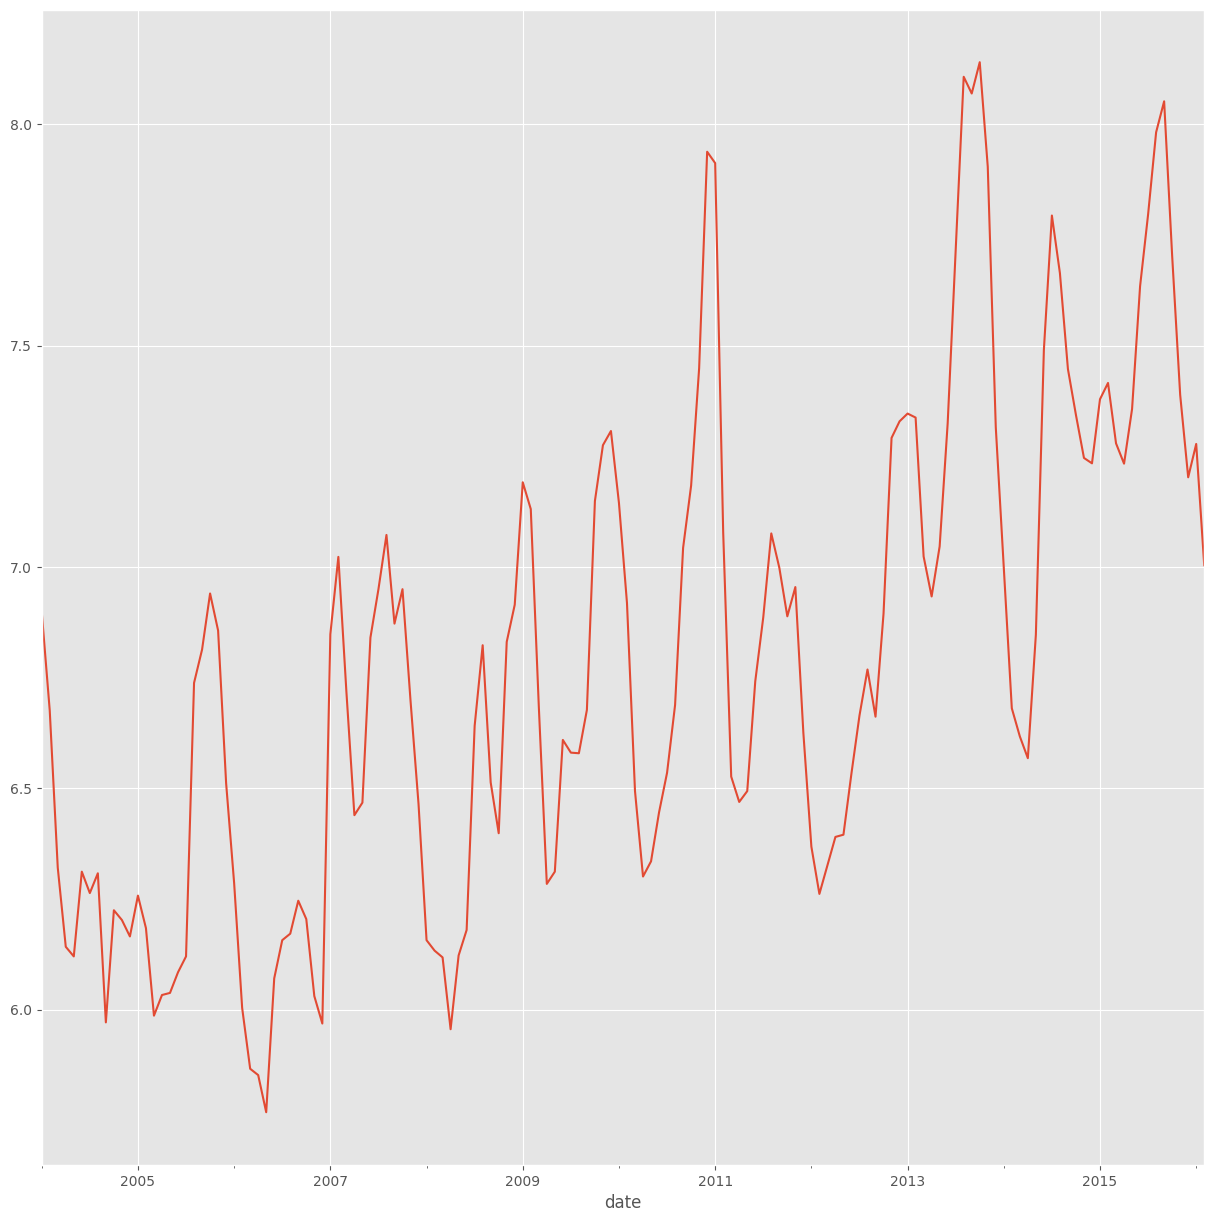

In [ ]:
dfBang.priceModLog.plot()

## 2.1. Прогнозирование средним

In [ ]:
model_mean_pred = dfBang.priceModLog.mean()

In [ ]:
# Запишем это значение в priceMean
dfBang["priceMean"] = np.exp(model_mean_pred)

<Axes: xlabel='date_time'>

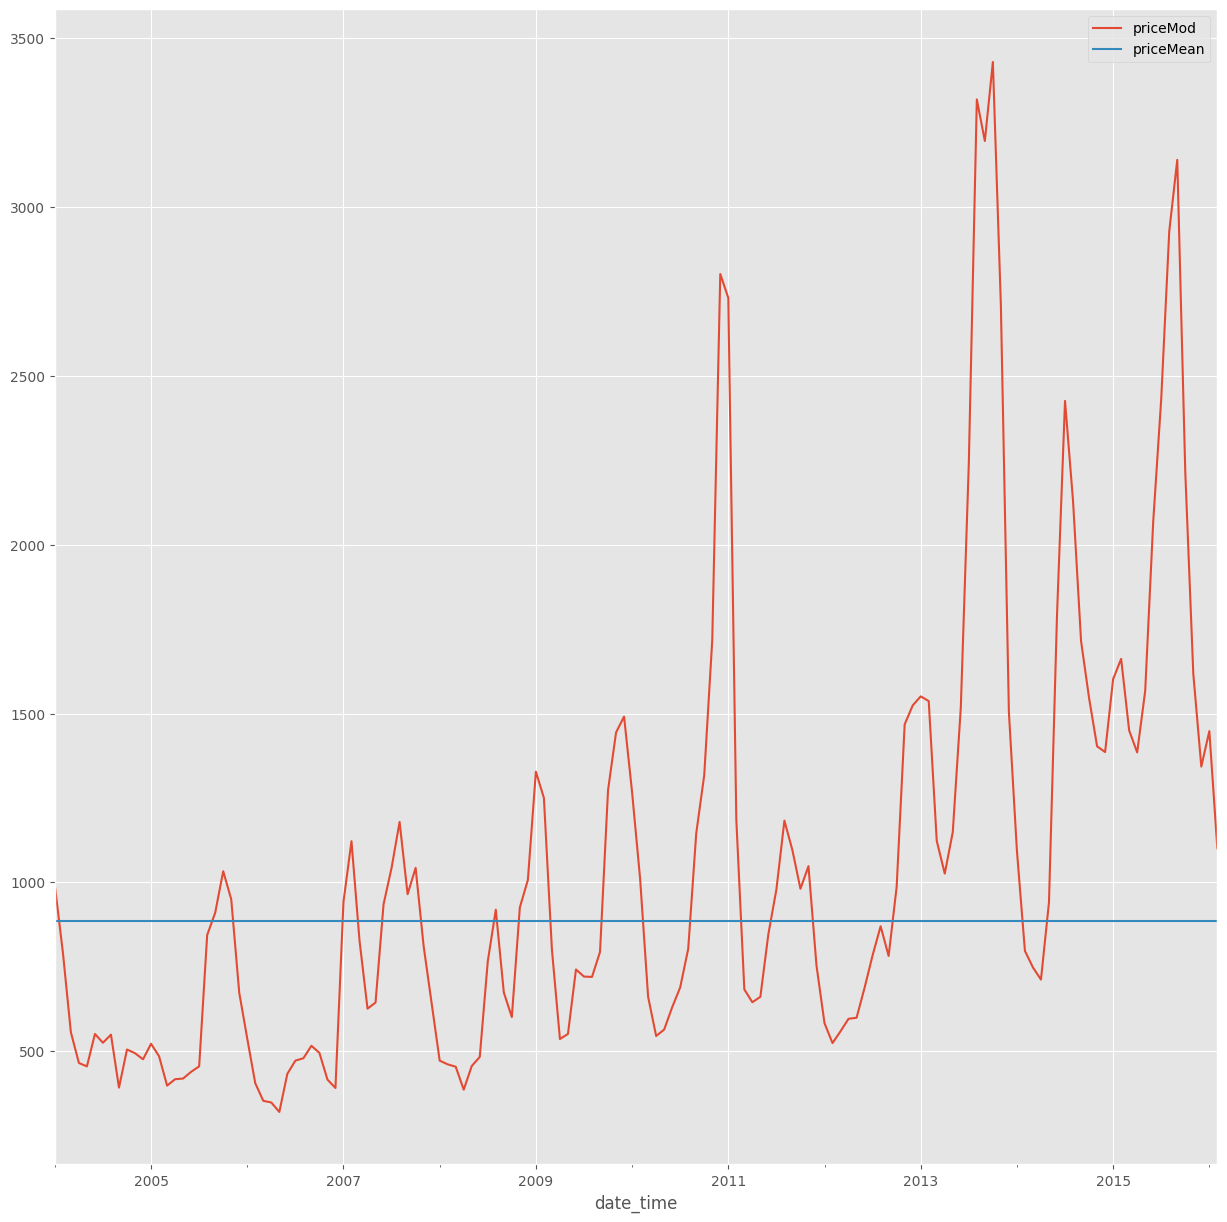

In [ ]:
dfBang.plot(kind="line", x="date_time", y=["priceMod", "priceMean"])

### Метрики качества

**Как мерить качество?**

Чтобы обучать регрессионные модели, нужно определиться, как именно измеряется качество предсказаний.   
Будем использовать метрику RMSE (Root Mean Squared Error) - корень среднего квадрата отклонения.

$$RMSE = \Sigma \sqrt{ (\hat{y} - y)^2/n} $$ ,
где $\hat{y}$ это предсказанное значение y

In [ ]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [ ]:
model_mean_RMSE = RMSE(dfBang.priceMean, dfBang.priceMod)
model_mean_RMSE

683.9533483996255

In [ ]:
dfBangResults = pd.DataFrame(columns=["Model", "Forecast", "RMSE"])
dfBangResults.head()

Empty DataFrame
Columns: [Model, Forecast, RMSE]
Index: []

In [ ]:
dfBangResults.loc[0, "Model"] = "Mean"
dfBangResults.loc[0, "Forecast"] = np.exp(model_mean_pred)
dfBangResults.loc[0, "RMSE"] = model_mean_RMSE
dfBangResults.head()

Model Forecast   RMSE
0  Mean   884.57 683.95

### ! Задание 4. Постройте модель средних для величины quantity

In [ ]:
### your code here
model_qmean_pred =

## 2.2. Линейная модель

Построим линейную зависимость между priceModLog and time.   
Уравнение регрессии строится с помощью метода наименьших квадратов.

In [ ]:
dfBang.head()

quantity  priceMod  date_time  priceModLog  priceMean
date                                                          
2004-01    227832       991 2004-01-01         6.90     884.57
2004-02    225133       793 2004-02-01         6.68     884.57
2004-03    221952       556 2004-03-01         6.32     884.57
2004-04    185150       465 2004-04-01         6.14     884.57
2004-05    137390       455 2004-05-01         6.12     884.57

In [ ]:
dfBang.dtypes

quantity                int64
priceMod                int64
date_time      datetime64[ns]
priceModLog           float64
priceMean             float64
dtype: object

In [ ]:
dfBang.date_time.min()

Timestamp('2004-01-01 00:00:00')

In [ ]:
dfBang["timeIndex"] = dfBang.date_time - dfBang.date_time.min()

In [ ]:
dfBang.dtypes

In [ ]:
dfBang["timeIndex"] = dfBang["timeIndex"] /np.timedelta64(1, 'D') / 30

In [ ]:
dfBang["timeIndex"] = dfBang["timeIndex"].round(0).astype(int)

In [ ]:
dfBang.timeIndex.tail()

date
2015-10    143
2015-11    144
2015-12    145
2016-01    146
2016-02    147
Freq: M, Name: timeIndex, dtype: int64

In [ ]:
dfBang.head()

quantity  priceMod  date_time  priceModLog  priceMean  timeIndex
date                                                                     
2004-01    227832       991 2004-01-01         6.90     884.57          0
2004-02    225133       793 2004-02-01         6.68     884.57          1
2004-03    221952       556 2004-03-01         6.32     884.57          2
2004-04    185150       465 2004-04-01         6.14     884.57          3
2004-05    137390       455 2004-05-01         6.12     884.57          4

In [ ]:
model_linear = smf.ols("priceModLog ~ timeIndex", data=dfBang).fit()

In [ ]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     140.7
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           4.53e-23
Time:                        17:16:31   Log-Likelihood:                -72.076
No. Observations:                 146   AIC:                             148.2
Df Residuals:                     144   BIC:                             154.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1121      0.066     93.100      0.000       5.982       6.242
timeIndex      0.0092      0.001     11.863      0.000       0.008       0.011
==============================================================================
Omnibus:                        4.759   Durbin-Watson:                   0.386
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.759
Skew:                           0.407   Prob(JB):                       0.0926
Kurtosis:                       2.653   Cond. No.                         169.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Выведем параметры нашей линейной модели

In [ ]:
model_linear.params

Intercept   6.11
timeIndex   0.01
dtype: float64

In [ ]:
c = model_linear.params[0]
c

<ipython-input-115-80d797a925f5>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c = model_linear.params[0]


6.112098862228062

In [ ]:
m = model_linear.params[1]
m

<ipython-input-116-a8449d21553d>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m = model_linear.params[1]


0.00915131936021671

In [ ]:
model_linear_pred = model_linear.predict()

In [ ]:
model_linear_pred

array([6.11209886, 6.12125018, 6.1304015 , 6.13955282, 6.14870414,
       6.15785546, 6.16700678, 6.1761581 , 6.18530942, 6.19446074,
       6.20361206, 6.21276338, 6.22191469, 6.23106601, 6.24021733,
       6.24936865, 6.25851997, 6.26767129, 6.27682261, 6.28597393,
       6.29512525, 6.30427657, 6.31342789, 6.32257921, 6.33173053,
       6.34088185, 6.35003317, 6.35918448, 6.3683358 , 6.37748712,
       6.38663844, 6.39578976, 6.40494108, 6.4140924 , 6.42324372,
       6.44154636, 6.45069768, 6.459849  , 6.459849  , 6.47815164,
       6.48730296, 6.49645428, 6.50560559, 6.51475691, 6.52390823,
       6.53305955, 6.54221087, 6.55136219, 6.56051351, 6.56966483,
       6.57881615, 6.58796747, 6.59711879, 6.60627011, 6.61542143,
       6.62457275, 6.63372407, 6.64287539, 6.6520267 , 6.66117802,
       6.67032934, 6.67948066, 6.68863198, 6.6977833 , 6.70693462,
       6.71608594, 6.72523726, 6.73438858, 6.7435399 , 6.75269122,
       6.76184254, 6.77099386, 6.78014518, 6.78929649, 6.79844

In [ ]:
dfBang["priceLinear"] = np.exp(model_linear_pred)

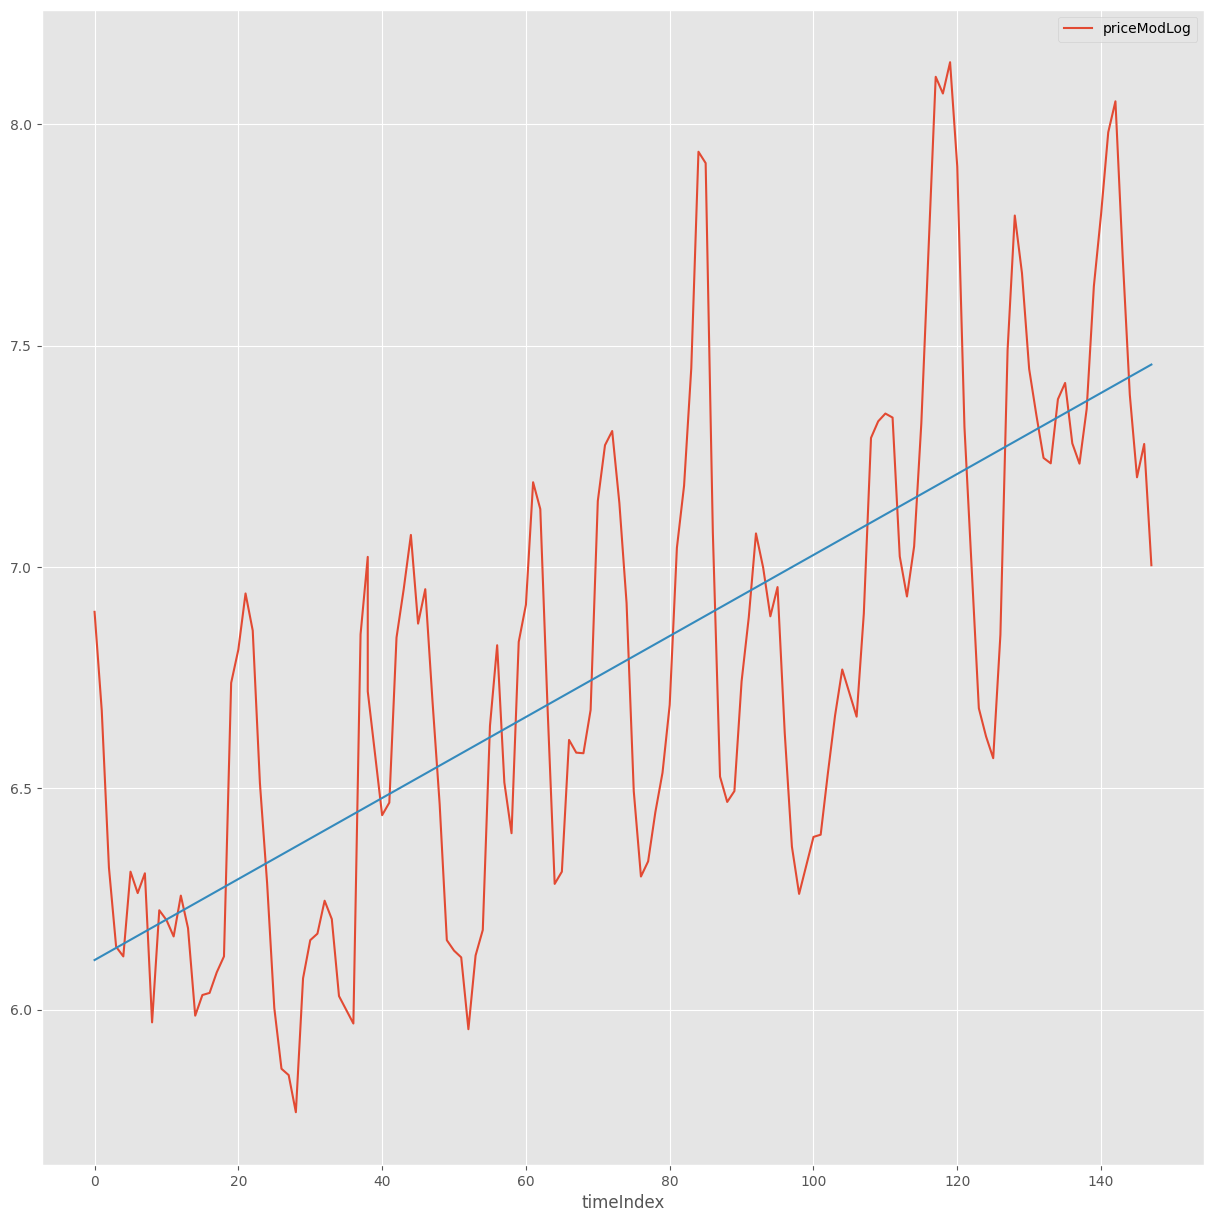

In [ ]:
dfBang.plot(kind="line", x="timeIndex", y="priceModLog")
plt.plot(dfBang.timeIndex, model_linear_pred, "-")

<Axes: xlabel='date'>

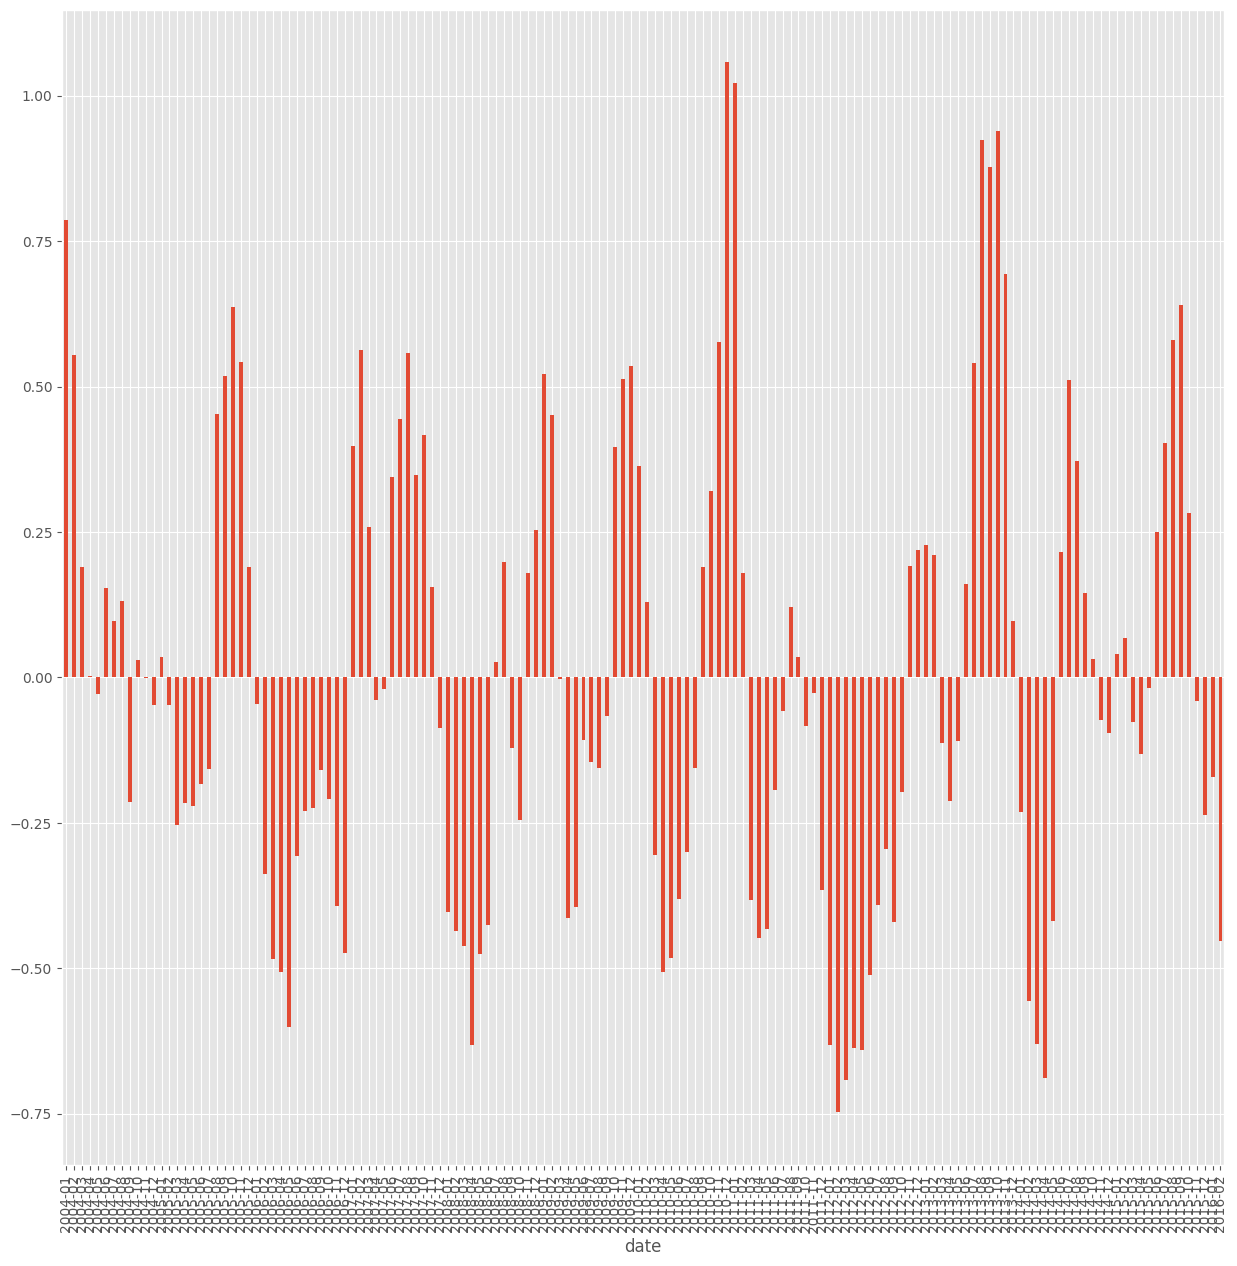

In [ ]:
model_linear.resid.plot(kind="bar")

Посчитаем ошибку RMSE на линейной модели:

In [ ]:
model_linear_RMSE = RMSE(dfBang.priceLinear, dfBang.priceMod)
model_linear_RMSE

517.8400897200523

In [ ]:
dfBangResults.loc[1, "Model"] = "Linear"
dfBangResults.loc[1, "Forecast"] = "Linear"
dfBangResults.loc[1, "RMSE"] = model_linear_RMSE
dfBangResults.head()

Model Forecast   RMSE
0    Mean   884.57 683.95
1  Linear   Linear 517.84

## 2.3 Линейная модель с регрессией

In [ ]:
## Построим регрессию, используя несколько переменных timeIndex и np.log(quantity)
model_linear_quantity = smf.ols(
    "priceModLog ~ timeIndex + np.log(quantity)", data=dfBang
).fit()

In [ ]:
model_linear_quantity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     74.62
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           6.41e-23
Time:                        18:56:40   Log-Likelihood:                -69.666
No. Observations:                 146   AIC:                             145.3
Df Residuals:                     143   BIC:                             154.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1901      0.880      4.763      0.000       2.451       5.929
timeIndex            0.0083      0.001      9.812      0.000       0.007       0.010
np.log(quantity)     0.1522      0.069      2.191      0.030       0.015       0.289
==============================================================================
Omnibus:                        5.079   Durbin-Watson:                   0.414
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                4.952
Skew:                           0.404   Prob(JB):                       0.0841
Kurtosis:                       2.598   Cond. No.                     2.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
dfBang.head()

quantity  priceMod  date_time  priceModLog  priceMean  timeIndex
date                                                                     
2004-01    227832       991 2004-01-01         6.90     884.57          0
2004-02    225133       793 2004-02-01         6.68     884.57          1
2004-03    221952       556 2004-03-01         6.32     884.57          2
2004-04    185150       465 2004-04-01         6.14     884.57          3
2004-05    137390       455 2004-05-01         6.12     884.57          4

In [ ]:
dfBang["priceLinearQuantity"] = np.exp(model_linear_quantity.predict())

In [ ]:
model_linear_q_pred = model_linear_quantity.predict()

<Axes: xlabel='timeIndex'>

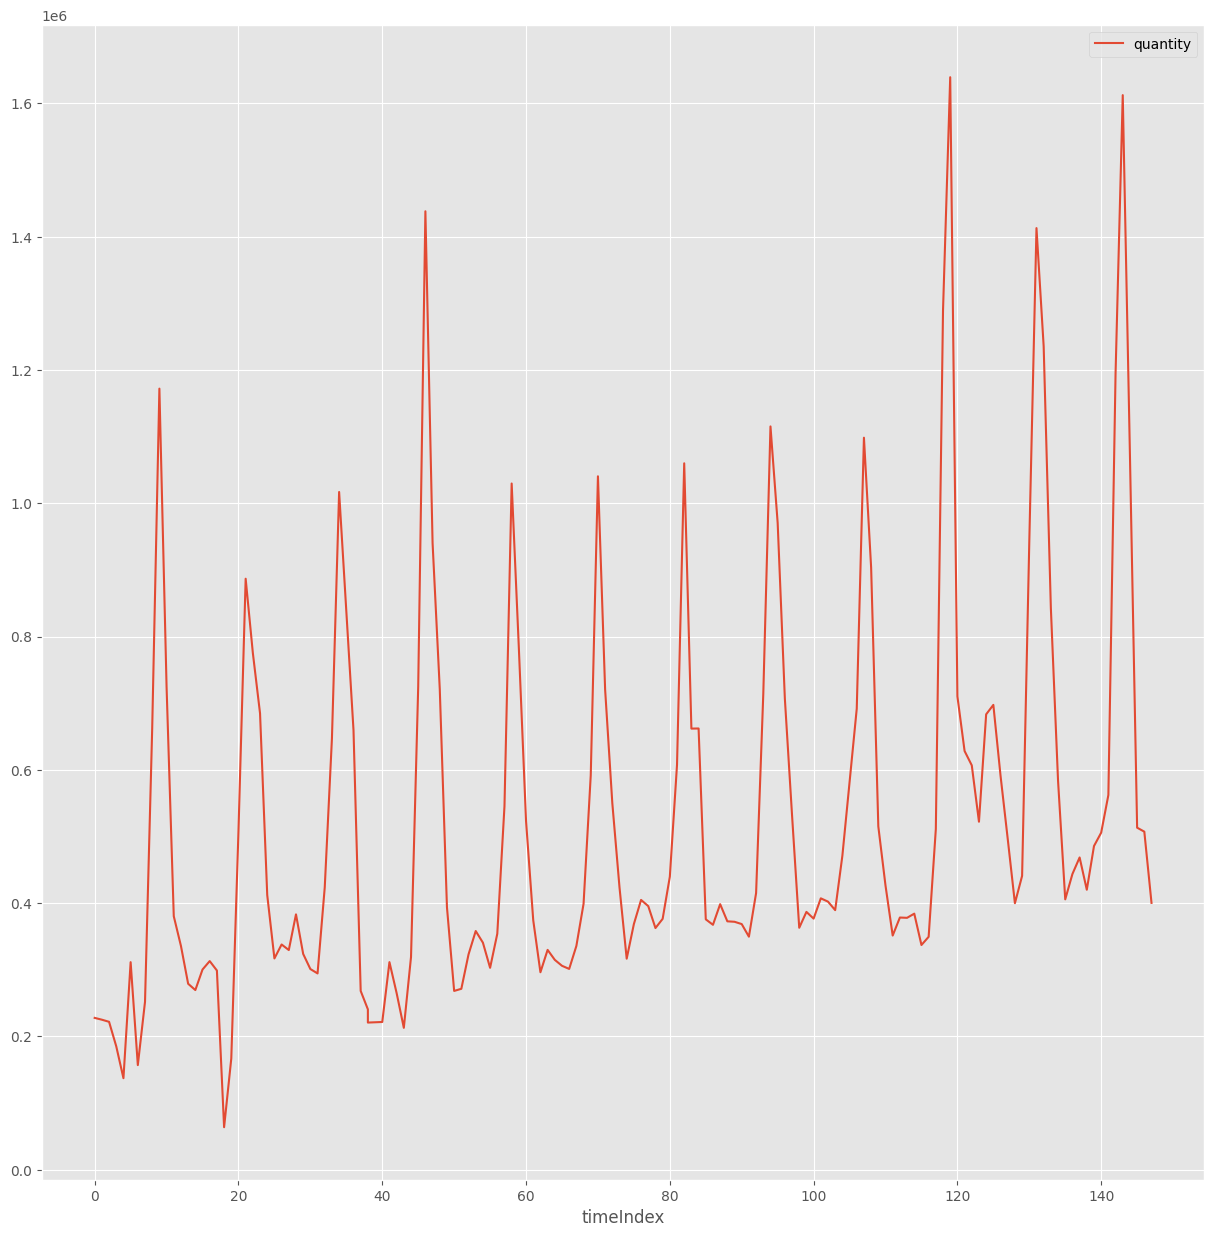

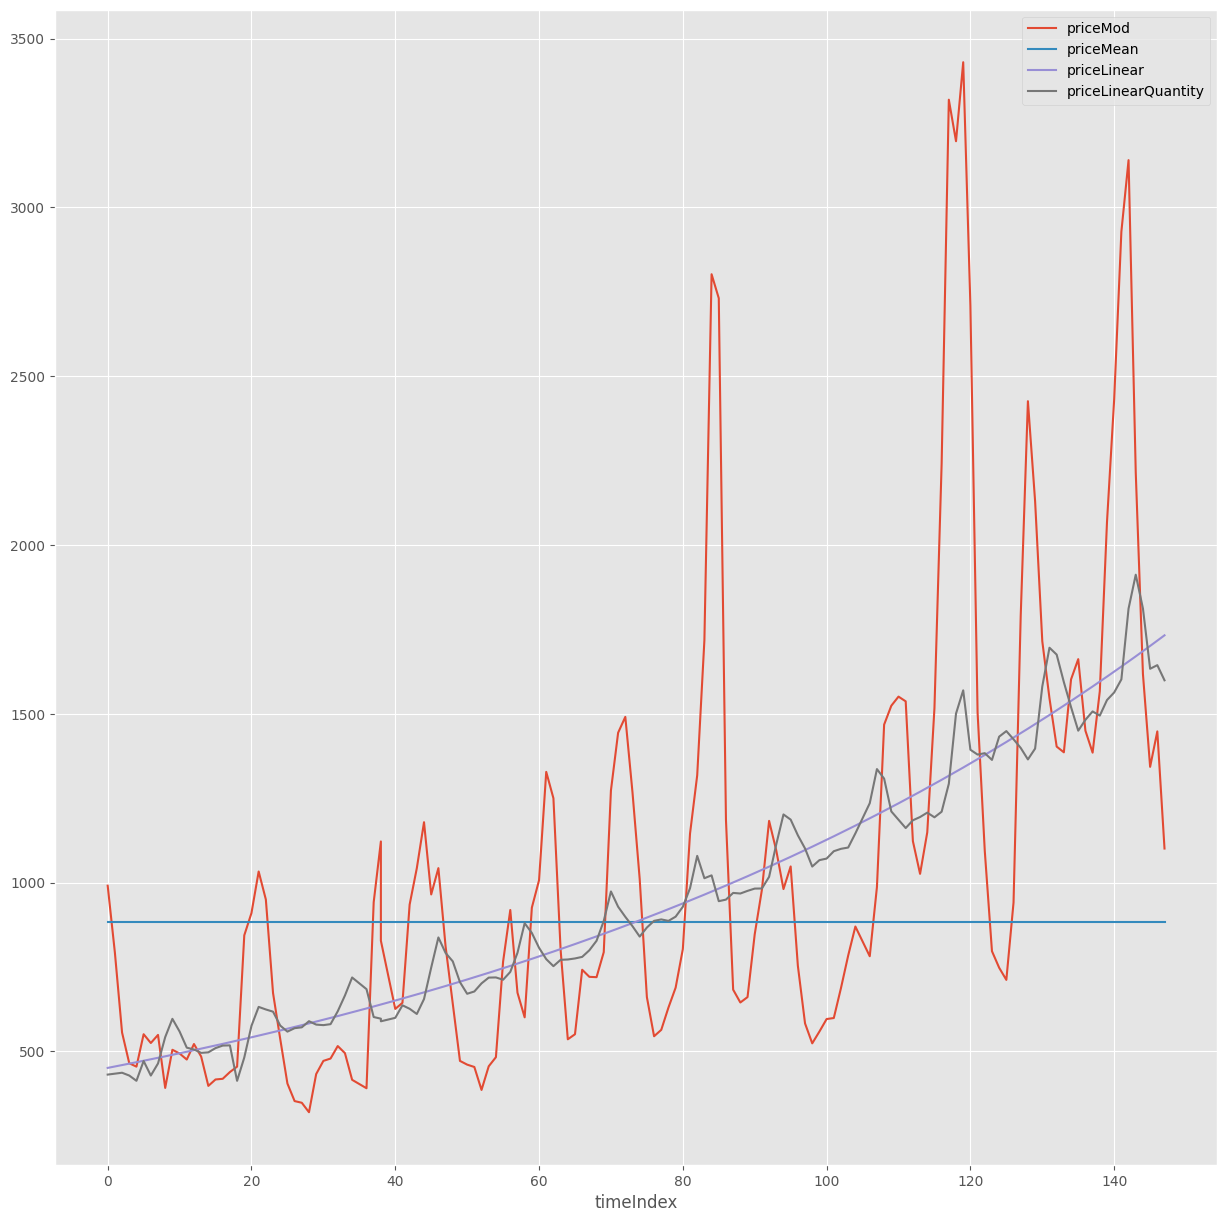

In [ ]:
dfBang.plot(kind="line", x="timeIndex", y="quantity")
dfBang.plot(
    kind="line",
    x="timeIndex",
    y=["priceMod", "priceMean", "priceLinear", "priceLinearQuantity"],
)

# 3 Выделение тренда и сезонности

При работе с временными рядами выделяют два действия:
- Дифференцирование - расчет разницы с определенным временным лагом
- Декомпозиция - моделирование как тренда, так и сезонности и удаление их из модели.

Предположим, что у вас имеются ежемесячные данные о пассажиропотоке на международных авиалиниях.  
Объем пассажиропотока имеет во времени возрастающий линейный тренд, и в ряде имеется ежегодно повторяющаяся закономерность - сезонность (большинство перевозок приходится на летние месяцы, кроме того, имеется пик меньшей высоты в районе декабрьских каникул).
Цель декомпозиции как раз и состоит в том, чтобы отделить эти компоненты, то есть разложить ряд на составляющую тренда, сезонную компоненту и оставшуюся нерегулярную составляющую.

![](https://anomaly.io/wp-content/uploads/2015/12/multiplicative-model.png)

То есть каждый уровень временного ряда формируется под воздействием большого числа факторов, которые условно можно подразделить на три группы:
- факторы, формирующие тенденцию ряда
- факторы, формирующие циклические колебания ряда
- случайные факторы  

Рассмотрим воздействие каждого фактора на временной ряд в отдельности.  
Большинство временных рядов экономических показателей имеют тенденцию,
характеризующую совокупное долговременное воздействие множества факторов на динамику изучаемого показателя.  
Все эти факторы, взятые в отдельности, могут оказывать разнонаправленное воздействие на исследуемый показатель. Однако в совокупности они формируют его возрастающую или убывающую тенденцию

В большинстве случаев фактический уровень временного ряда можно представить как сумму или произведение трендовой, циклической и случайной компонент. Модель, в которой временной ряд представлен как сумма перечисленных компонент, называется **аддитивной** моделью временного ряда. Модель, в которой временной ряд представлен как произведение перечисленных компонент, называется **мультипликативной** моделью временного ряда.

**Аддитивная модель**
$${Y_t} = t (trend) + s (seasonality) + r (residual)$$

![](https://miro.medium.com/max/1360/0*JWWglnH4RBR-SbxC.png)

**Мультипликативная модель**
$${Y_t} = t (trend) * s (seasonality) * r (residual)$$

Как видим, отличие мультипликативной модели от аддитивной состоит в том,
что в мультипликативной модели сезонная и случайная составляющие определены в виде относительных величин (коэффициентов),
а в аддитивной модели – в виде абсолютных величин.   
Эти модели в практических расчетах дадут близкие результаты, если амплитуда колебаний уровней ряда слабо изменяется во времени


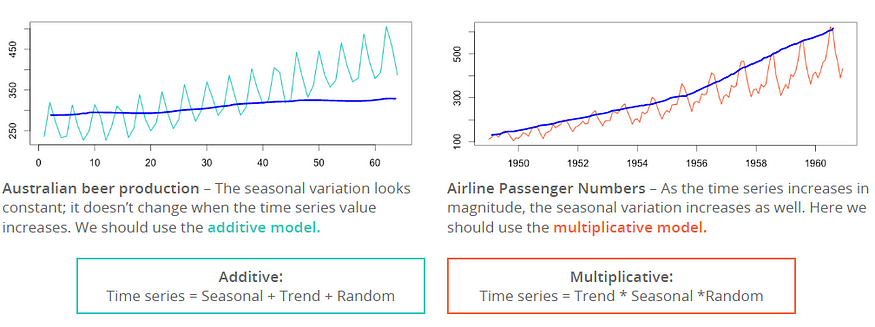

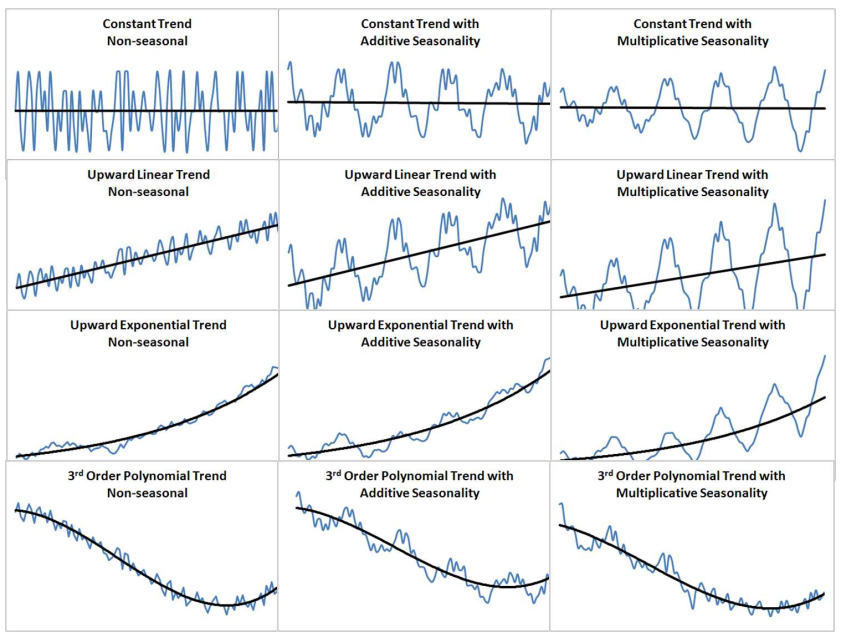

### Расчет лагов
Представим временной ряд в виде последовательности разницы между значениями.  
Рассчитаем лаги, выведем их на графике

In [ ]:
# Рассчитаем лаги
dfBang["priceModLogShift1"] = dfBang.priceModLog.shift()

<Axes: xlabel='priceModLogShift1', ylabel='priceModLog'>

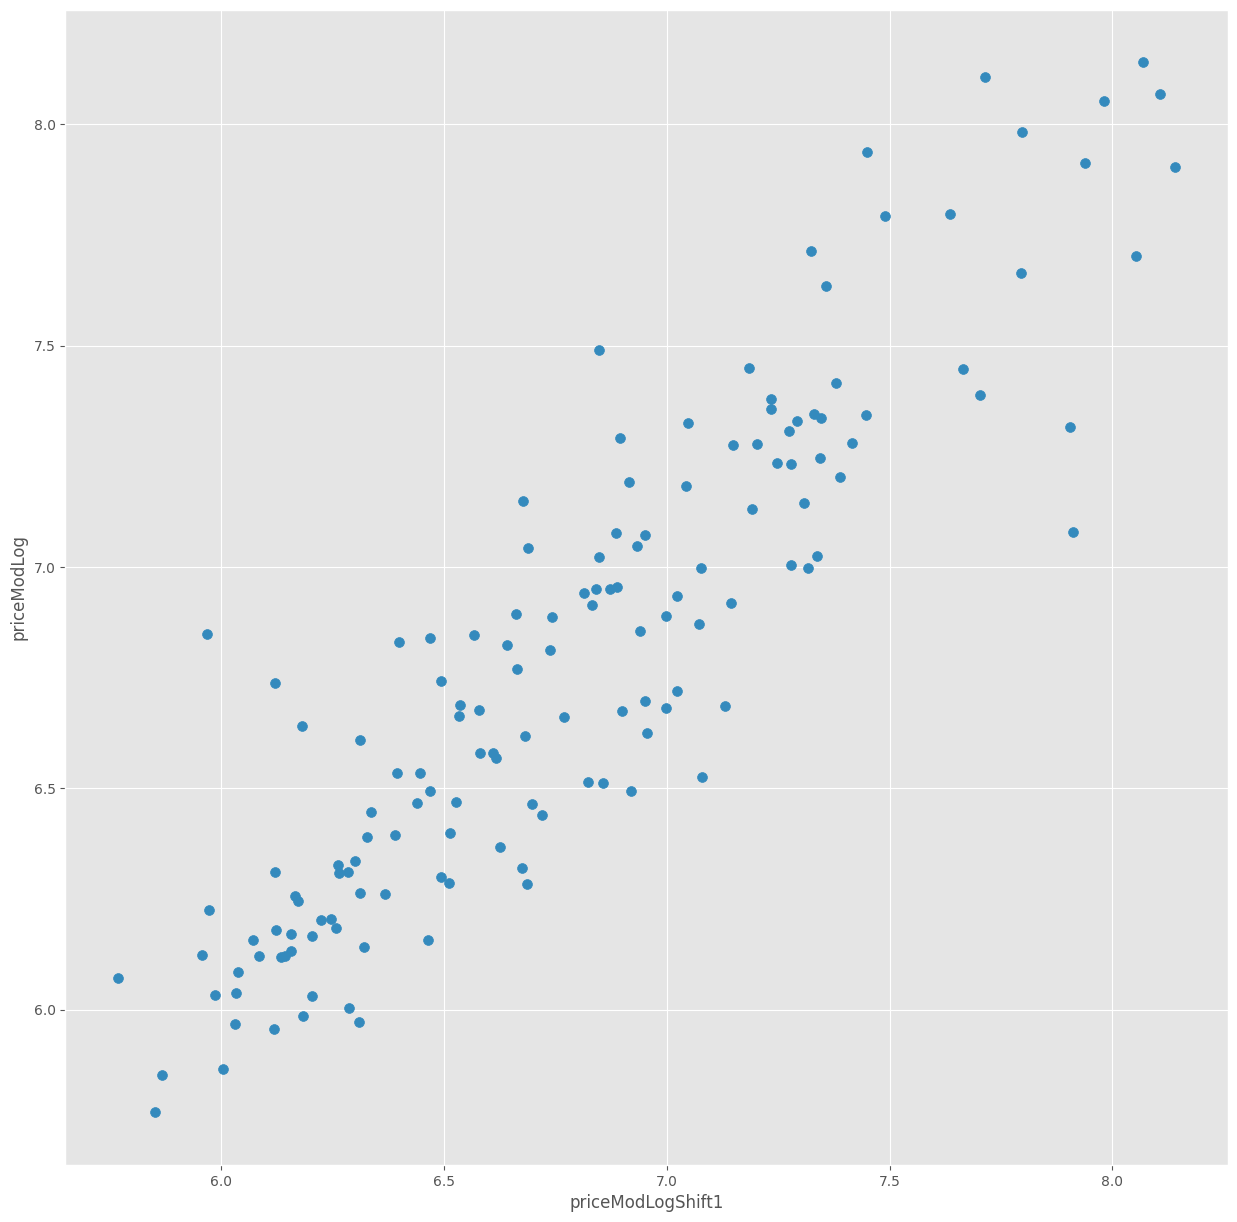

In [ ]:
# Выведем на графике priceModLog и priceModLogShift1
dfBang.plot(kind="scatter", y="priceModLog", x="priceModLogShift1", s=50)

In [ ]:
dfBang["priceModLogDiff"] = dfBang.priceModLog - dfBang.priceModLogShift1

<Axes: xlabel='date'>

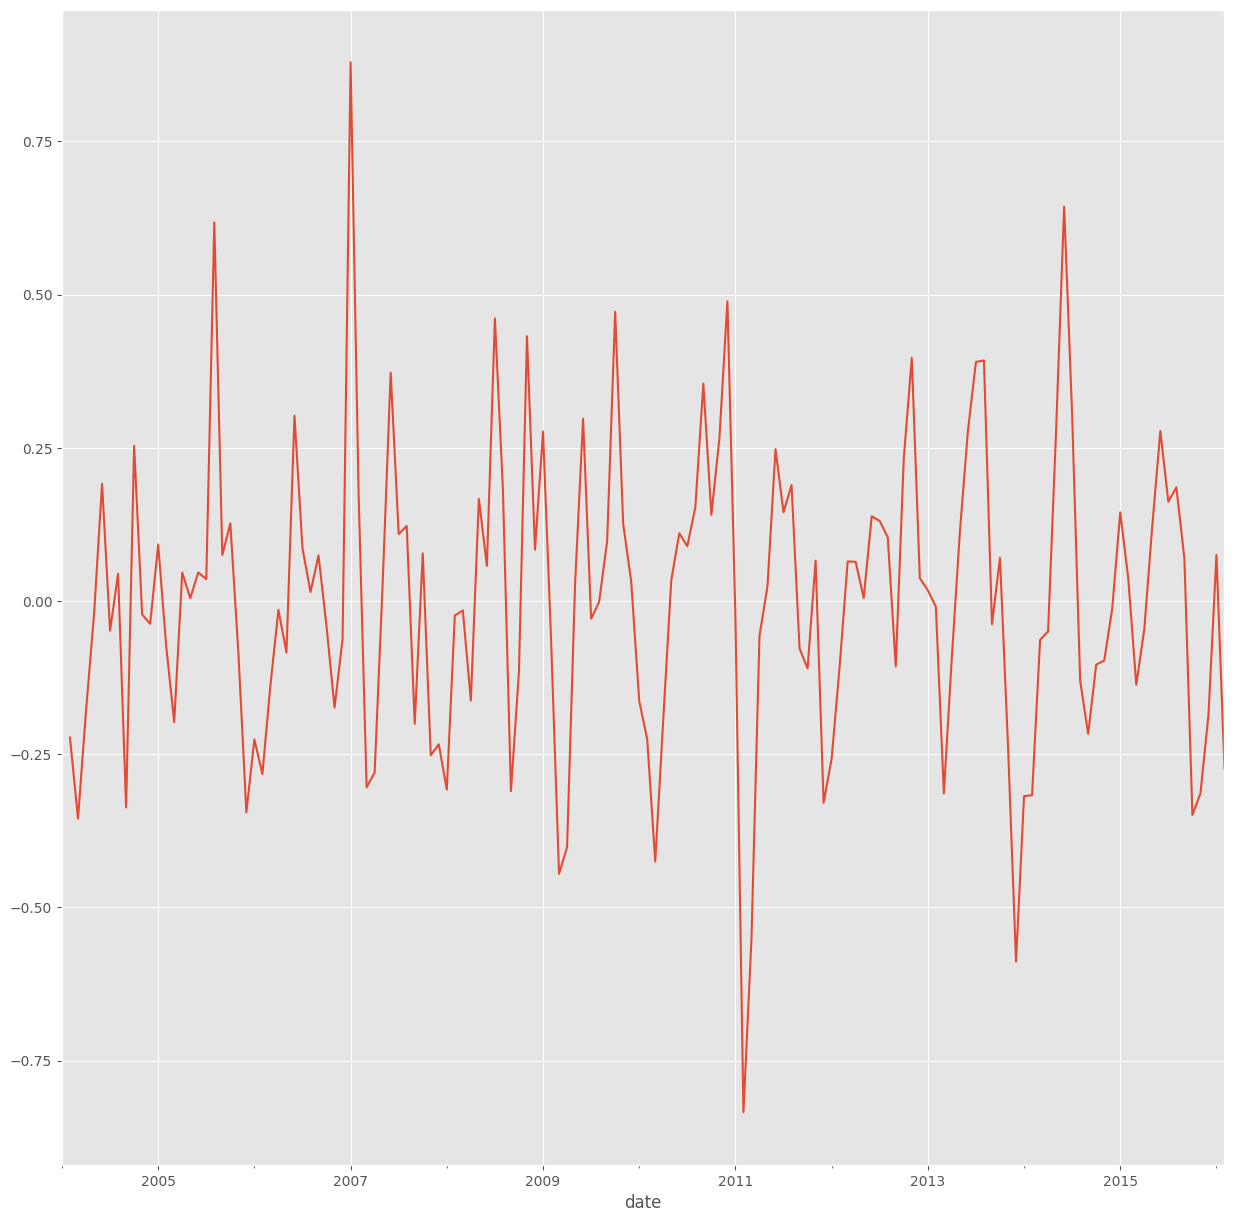

In [ ]:
dfBang.priceModLogDiff.plot()

### Декомпозиция
Декомпозируем наш временной ряд на тренд и сезонность

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
dfBang.index = pd.to_datetime(dfBang.index)

In [ ]:
dfBang.head()

quantity  priceMod  date_time  priceModLog  priceMean  timeIndex  \
date                                                                           
2004-01-01    227832       991 2004-01-01         6.90     884.57          0   
2004-02-01    225133       793 2004-02-01         6.68     884.57          1   
2004-03-01    221952       556 2004-03-01         6.32     884.57          2   
2004-04-01    185150       465 2004-04-01         6.14     884.57          3   
2004-05-01    137390       455 2004-05-01         6.12     884.57          4   

            priceLinearQuantity  priceLinear  priceModLogShift1  \
date                                                              
2004-01-01               431.45       451.28                NaN   
2004-02-01               434.27       455.43               6.90   
2004-03-01               436.96       459.62               6.68   
2004-04-01               428.63       463.85               6.32   
2004-05-01               413.03       468.11               6.14   

            priceModLogDiff  
date                         
2004-01-01              NaN  
2004-02-01            -0.22  
2004-03-01            -0.36  
2004-04-01            -0.18  
2004-05-01            -0.02

In [ ]:
decomposition = seasonal_decompose(dfBang.priceModLog, model="additive")

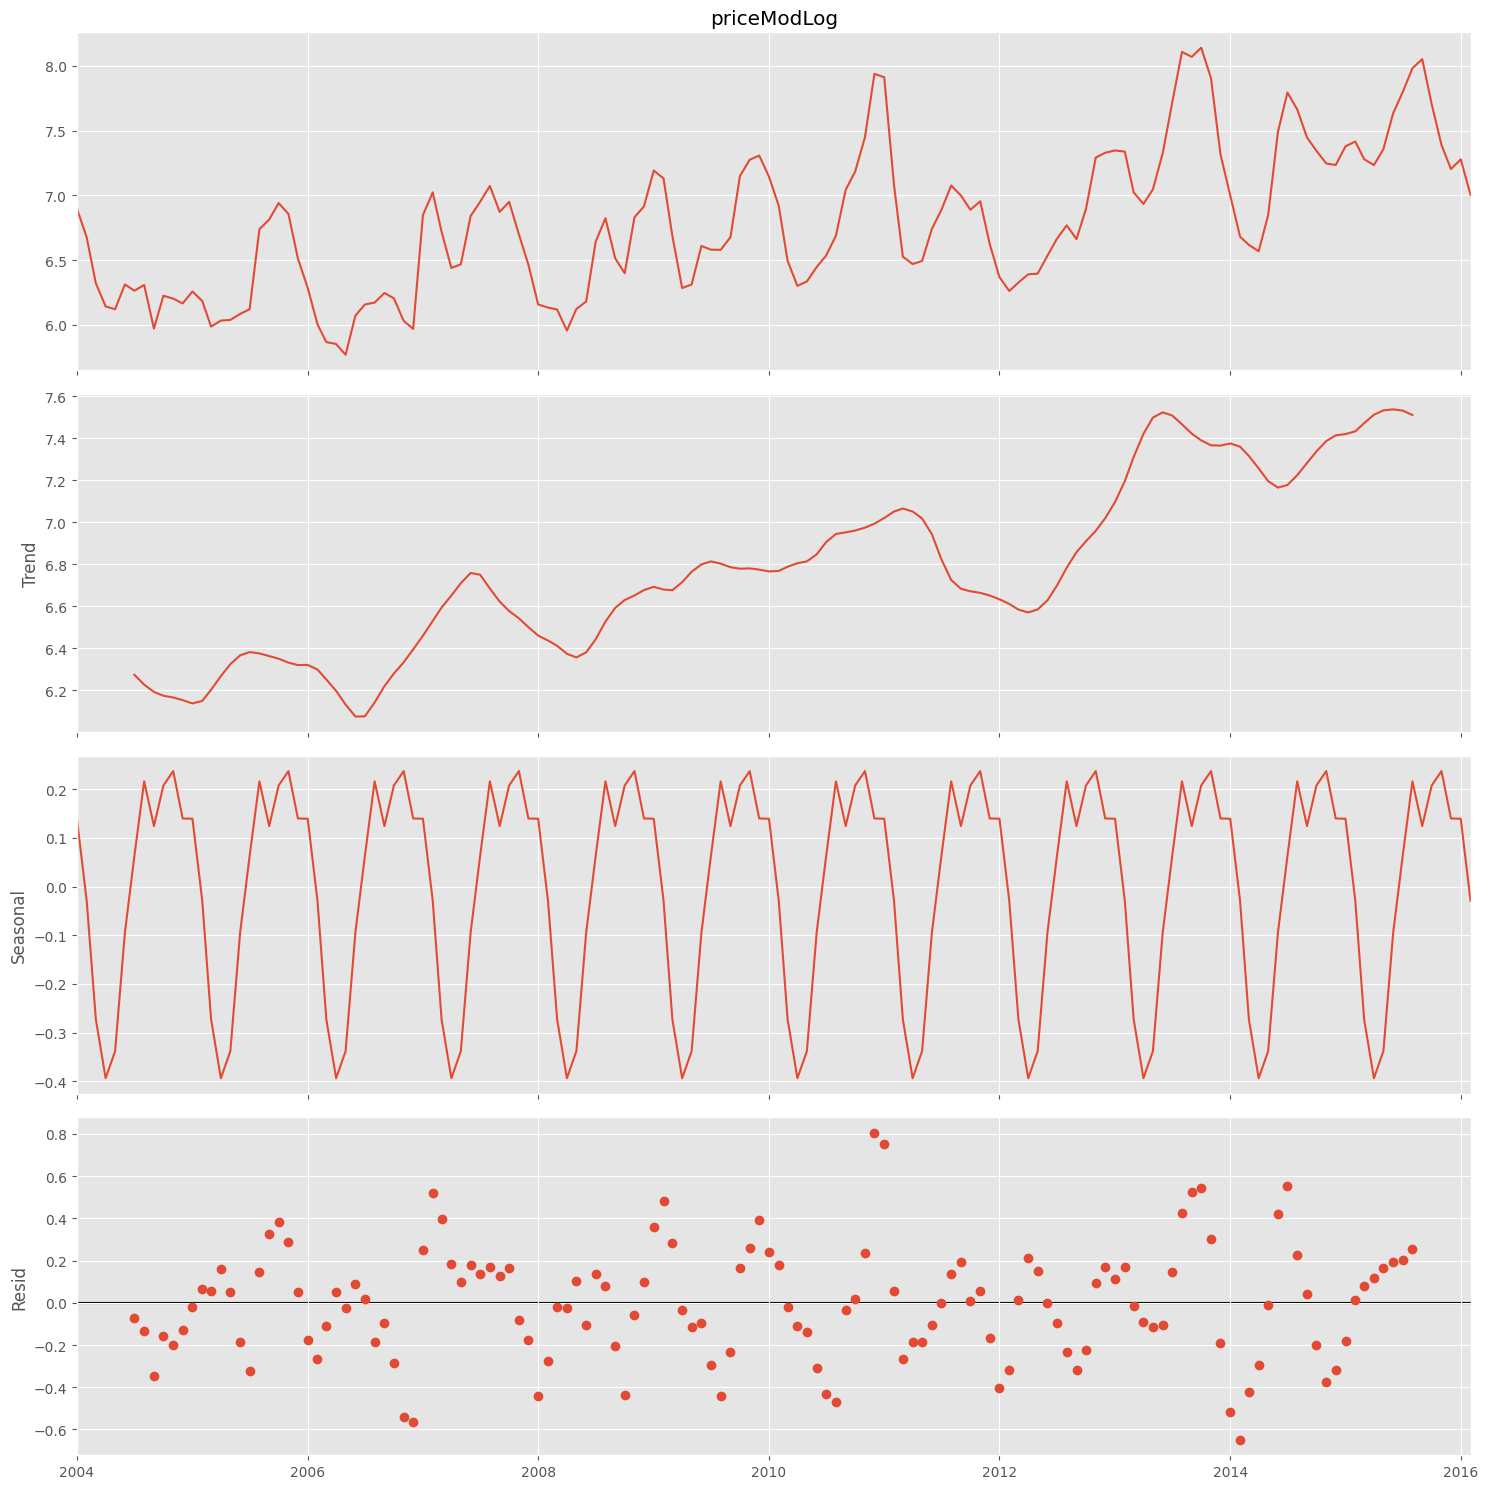

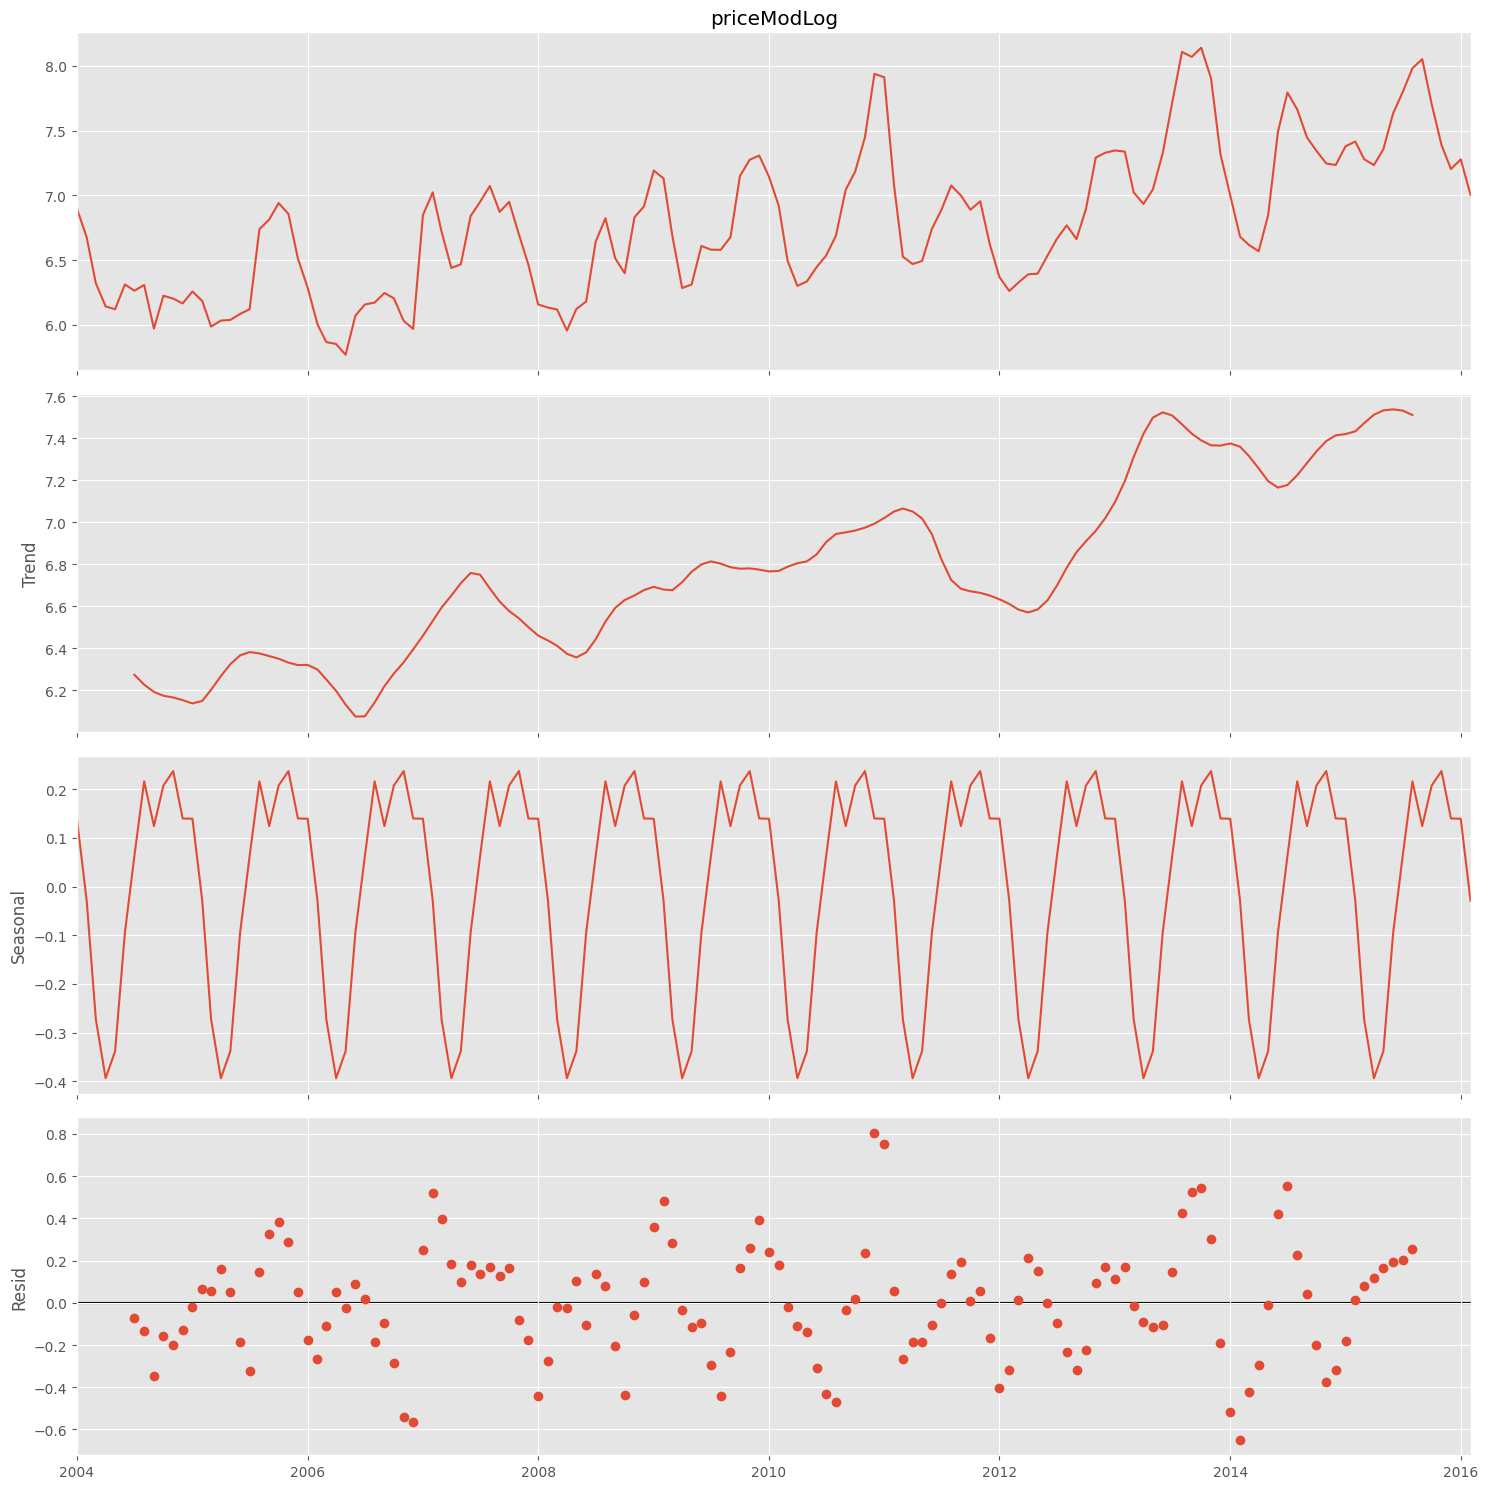

In [ ]:
decomposition.plot()

In [ ]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
# Построим ряд по тренду и сезонности
dfBang["priceDecomp"] = np.exp(trend + seasonal)

In [ ]:
# Расчет RMSE
model_Decomp_RMSE = RMSE(dfBang.priceDecomp, dfBang.priceMod)
model_Decomp_RMSE

374.1085846480237

<Axes: xlabel='timeIndex'>

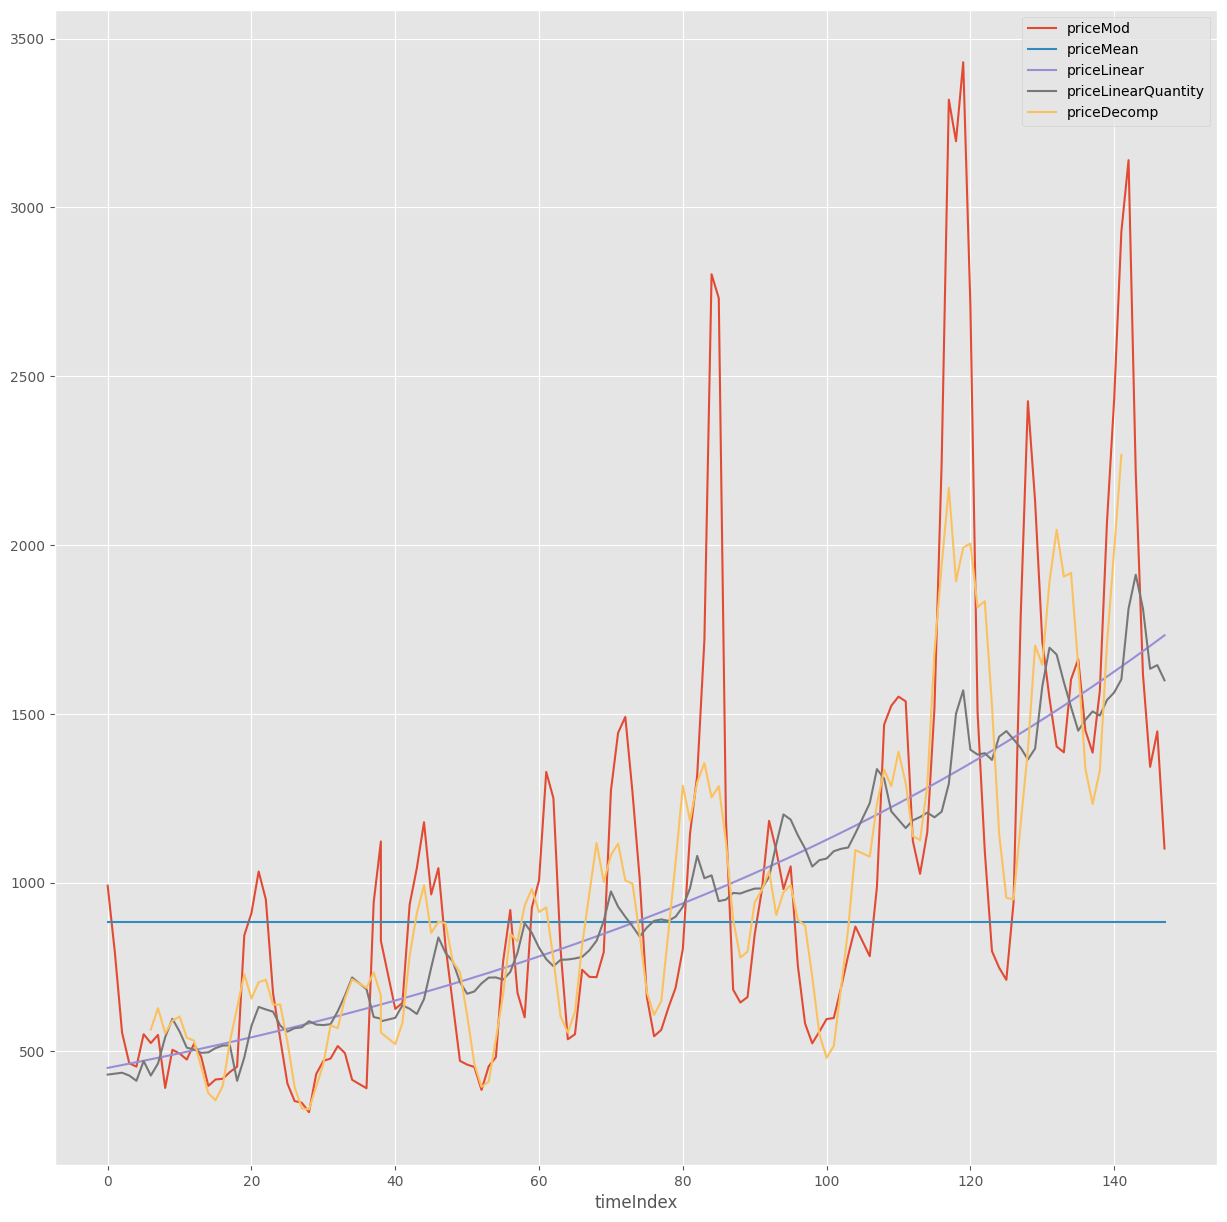

In [ ]:
dfBang.plot(
    kind="line",
    x="timeIndex",
    y=["priceMod", "priceMean", "priceLinear", "priceLinearQuantity", "priceDecomp"],
)

In [ ]:
dfBangResults

Model Forecast   RMSE
0  Mean   884.57 683.95

In [ ]:
dfBangResults.loc[3, "Model"] = "priceDecomp"
dfBangResults.loc[3, "Forecast"] = "priceDecomp"
dfBangResults.loc[3, "RMSE"] = model_Decomp_RMSE
dfBangResults.head()

Model     Forecast   RMSE
0         Mean       884.57 683.95
3  priceDecomp  priceDecomp 374.11

### ! Задание 5. Декомпозируйте ряд остатков quantity

In [ ]:
### your code here

# 4 Стационарность ряда

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как стационарность.  
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках:

![](https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png)  
Временной ряд справа не является стационарным, так как его матожидание со временем растёт

![](https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png)  
Здесь не повезло с дисперсией — разброс значений ряда существенно варьируется в зависимости от периода

![](https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png)  
На последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций


**Почему стационарность так важна?**

По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

In [ ]:
test = sm.tsa.adfuller(dfBang.priceMod)
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["5%"]:
    print("Есть единичные корни, ряд не стационарен")
else:
    print("Единичных корней нет, ряд стационарен")

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  -4.004401077671534
p-value:  0.00138764044231547
Critical values:  {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}
Единичных корней нет, ряд стационарен


# 5 Построение модели АRIMA

Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.  
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:  
- p — порядок компоненты AR
- d — порядок интегрированного ряда (порядок разности временного ряда)
- q — порядок компонетны MA  


Для определения p и q нам надо изучить авторкорреляционную (ACF) и частично автокорреляционную (PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA.

PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.  

Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: acf и pacf.  
Можем построить графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов.

In [ ]:
ts = dfBang.priceModLog
ts_diff = dfBang.priceModLogDiff
ts_diff.dropna(inplace=True)

In [ ]:
# ACF и PACF
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
lag_acf = acf(ts_diff, nlags=20)

In [ ]:
lag_acf

array([ 1.        ,  0.40215445, -0.02855346, -0.21472715, -0.23756032,
       -0.26332645, -0.22038359, -0.08576989, -0.0754398 ,  0.01497797,
        0.12361818,  0.20862956,  0.158123  ,  0.02053933, -0.01290934,
       -0.07097602, -0.17993659, -0.09514604, -0.04878255, -0.08854117,
       -0.18810881])

In [ ]:
ACF = pd.Series(lag_acf)

In [ ]:
ACF

0     1.00
1     0.40
2    -0.03
3    -0.21
4    -0.24
5    -0.26
6    -0.22
7    -0.09
8    -0.08
9     0.01
10    0.12
11    0.21
12    0.16
13    0.02
14   -0.01
15   -0.07
16   -0.18
17   -0.10
18   -0.05
19   -0.09
20   -0.19
dtype: float64

<Axes: >

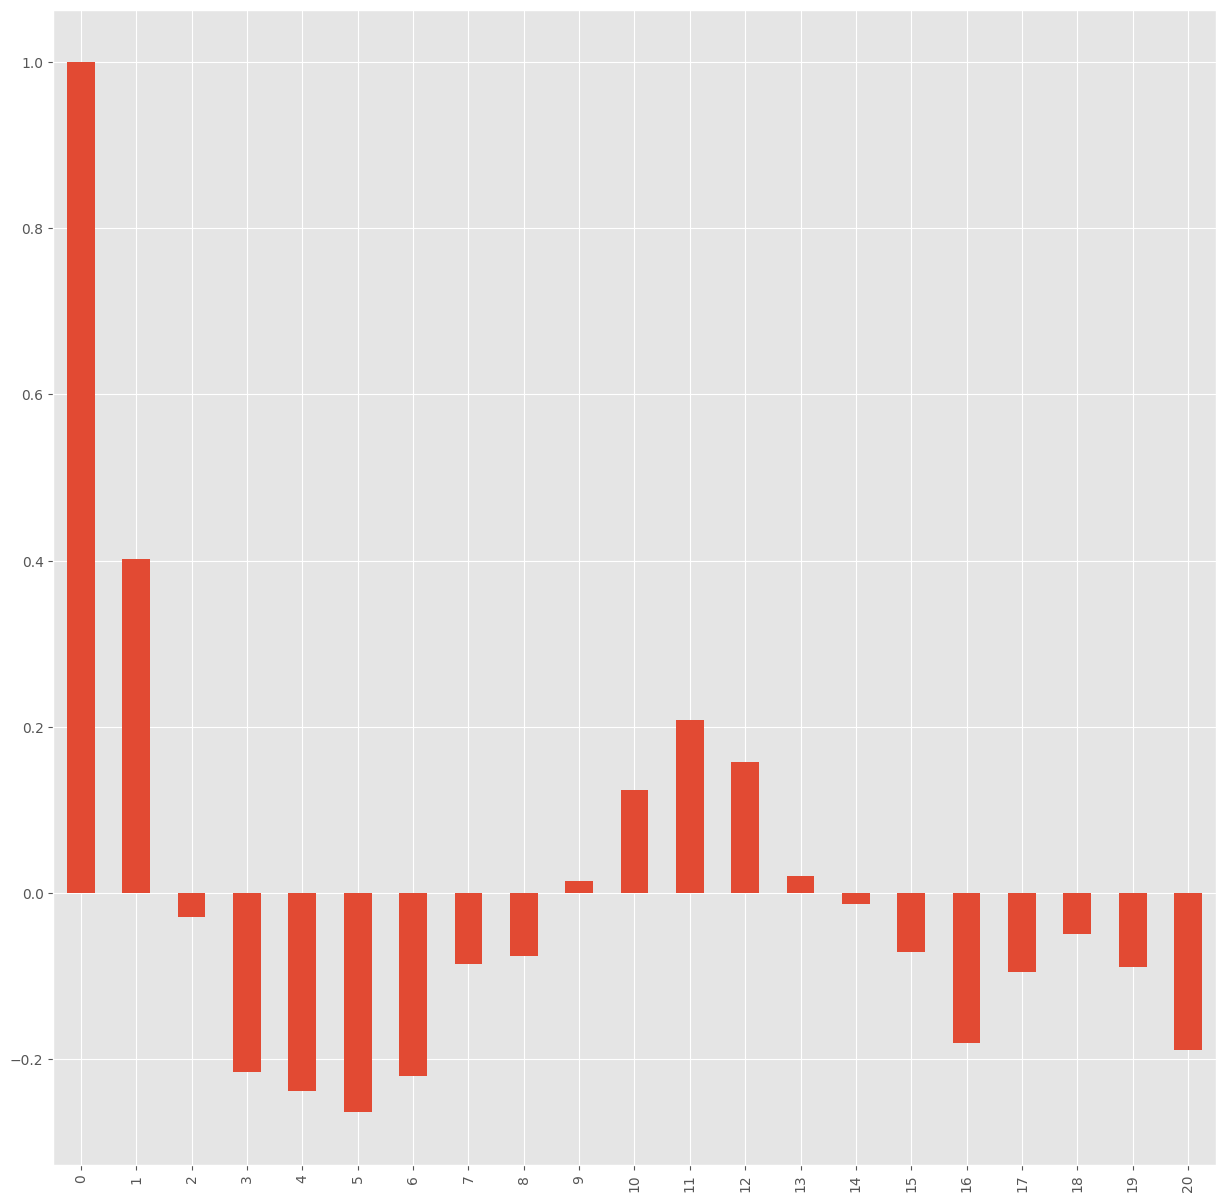

In [ ]:
ACF.plot(kind="bar")

In [ ]:
lag_pacf = pacf(ts_diff, nlags=20, method="ols")

In [ ]:
PACF = pd.Series(lag_pacf)

<Axes: >

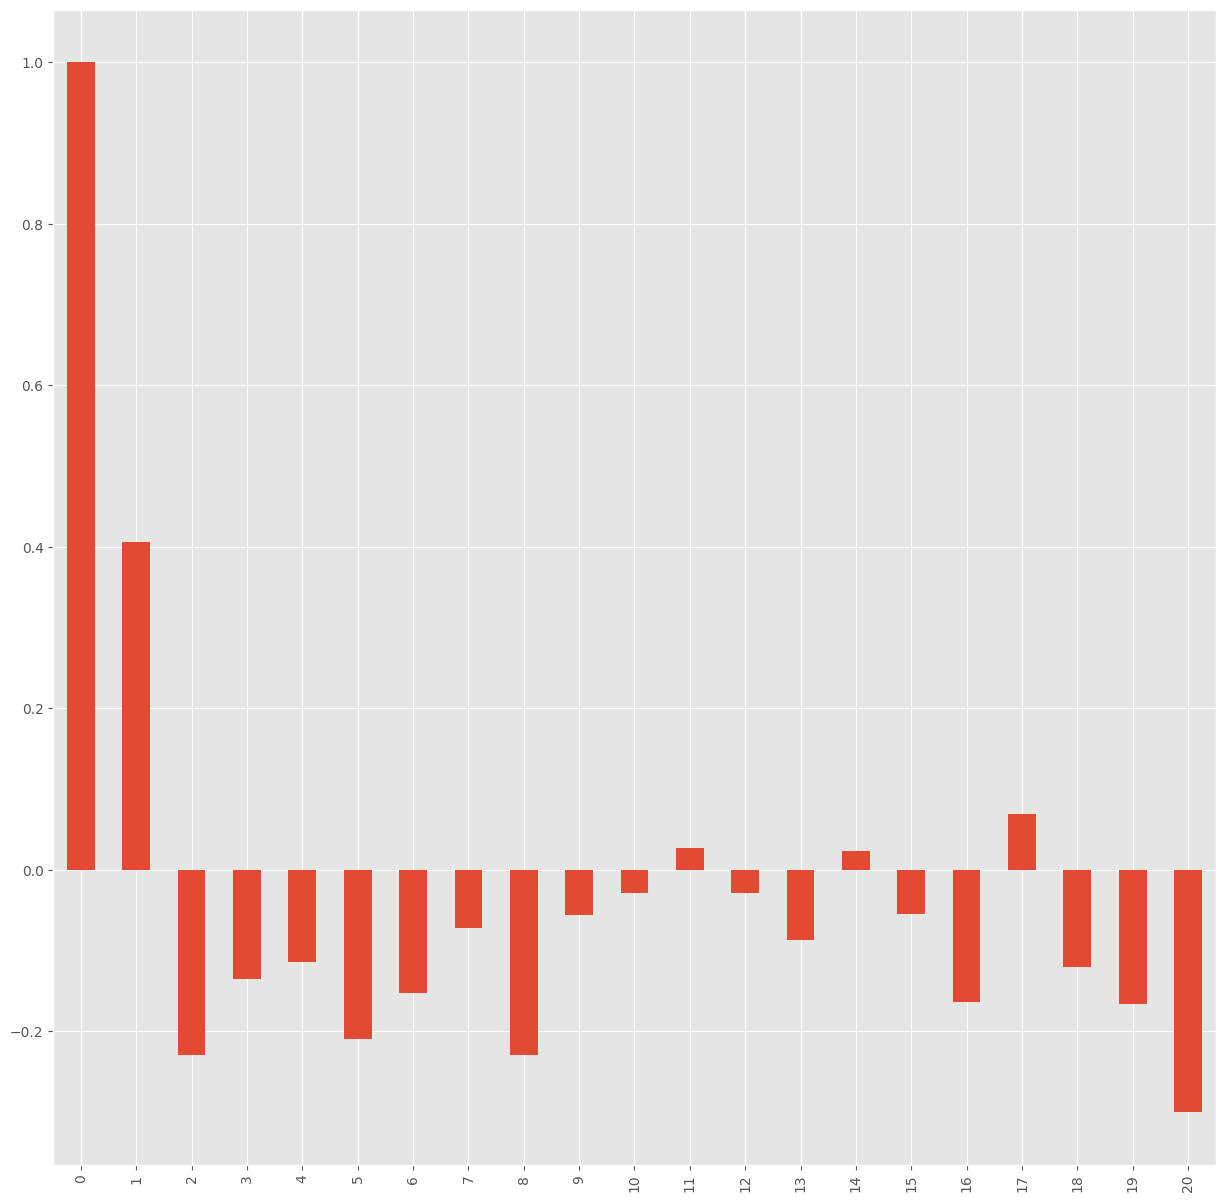

In [ ]:
PACF.plot(kind="bar")

## Построим модель ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
ts_diff.head()

date
2004-02-01   -0.22
2004-03-01   -0.36
2004-04-01   -0.18
2004-05-01   -0.02
2004-06-01    0.19
Freq: MS, Name: priceModLogDiff, dtype: float64

In [ ]:
# ARIMA Model (1,0,1)
model_AR1MA = ARIMA(ts_diff, order=(1, 0, 1))

In [ ]:
results_ARIMA = model_AR1MA.fit()

In [ ]:
results_ARIMA.fittedvalues.head()

date
2004-02-01   -0.00
2004-03-01   -0.09
2004-04-01   -0.14
2004-05-01   -0.04
2004-06-01    0.00
Freq: MS, dtype: float64

<Axes: xlabel='date'>

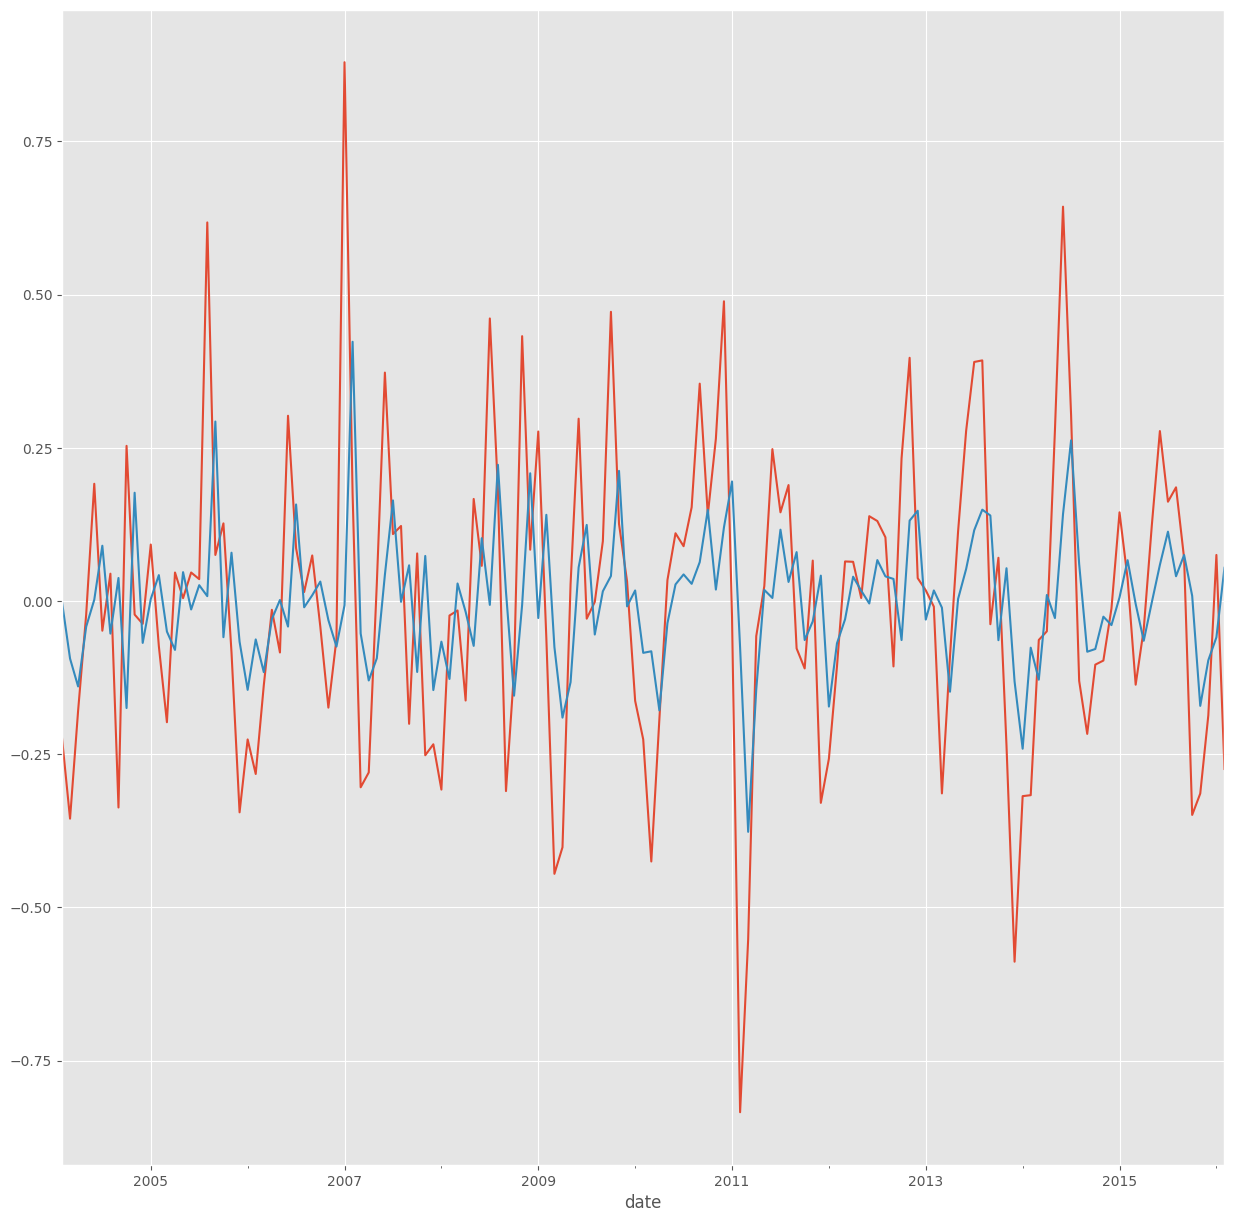

In [ ]:
ts_diff.plot()
results_ARIMA.fittedvalues.plot()

# 6 Машинное обучение. Линейная регрессия для прогнозирования

Будем прогнозировать количество проданного товара в городе Бангалор (Индия)

## Предобработка временного ряда

Импорт библиотек

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# данные по продажам в Индии в различных городах и штатах
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")

df.date = pd.DatetimeIndex(df.date)

# Отсортируем и добавим date в индекс
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

Оставим только целевой ряд (`quantity`)

In [ ]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

# Удалим лишние столбцы
ts = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax", "priceMod", "date"], axis=1
)

ts.head()

quantity
date             
2004-01    227832
2004-02    225133
2004-03    221952
2004-04    185150
2004-05    137390

Посмотрим как ведет себя временной ряд

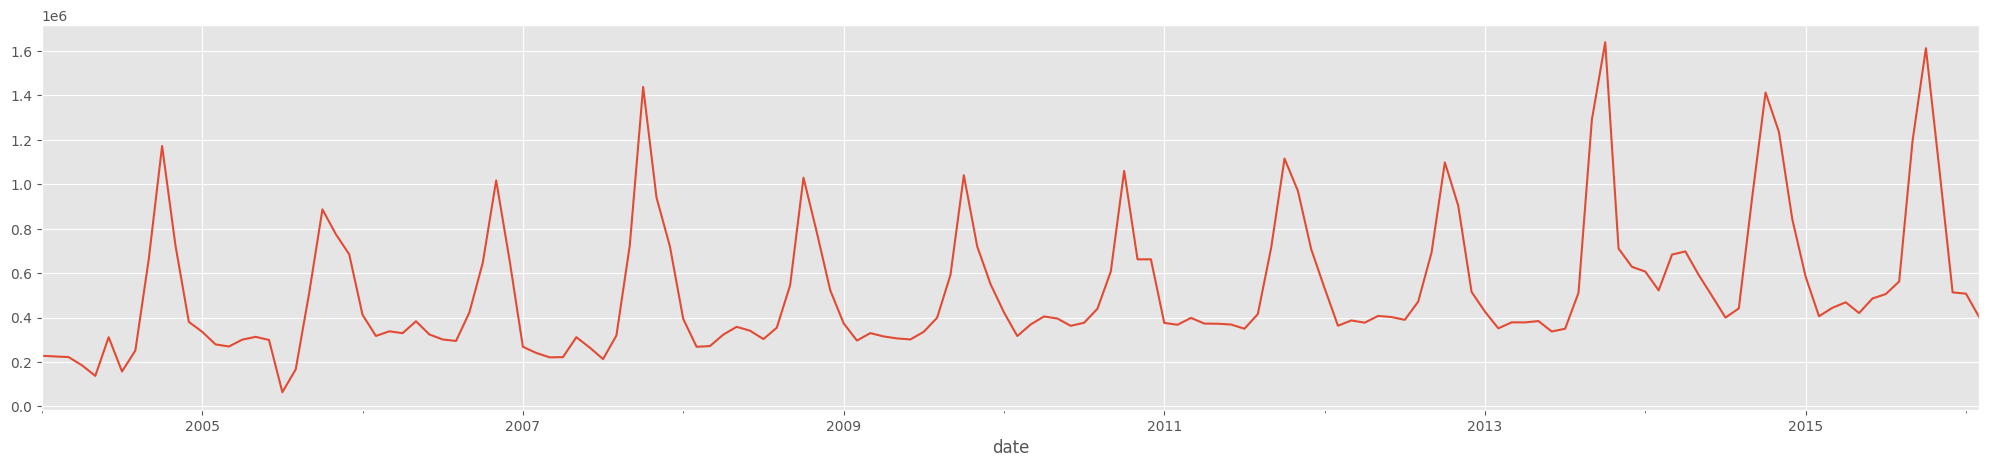

In [ ]:
ts.quantity.plot(figsize=(25,5));

## Машинное обучение для прогнозирования временных рядов

## Добавляем лаги

Извлеките первые 7 лаговых признаков из ряда (лаг на 1, 2 ... 7 месяцев).

Чему равно первое (самое старое) известное значение лага 4 периода назад (lag_4)? Ответ округлите до целого числа.

In [ ]:
lag_start = 1
lag_end = 7
for i in range(lag_start, lag_end):
  ts[f"lag_{i}"] = ts.quantity.shift(i)
ts.head()

quantity     lag_1     lag_2     lag_3     lag_4  lag_5  lag_6
date                                                                   
2004-01    227832       NaN       NaN       NaN       NaN    NaN    NaN
2004-02    225133 227832.00       NaN       NaN       NaN    NaN    NaN
2004-03    221952 225133.00 227832.00       NaN       NaN    NaN    NaN
2004-04    185150 221952.00 225133.00 227832.00       NaN    NaN    NaN
2004-05    137390 185150.00 221952.00 225133.00 227832.00    NaN    NaN

Выкиньте строчки с пропущенными значениями.

In [ ]:
ts = ts.dropna()

### Разбиение на train и test для временных рядов

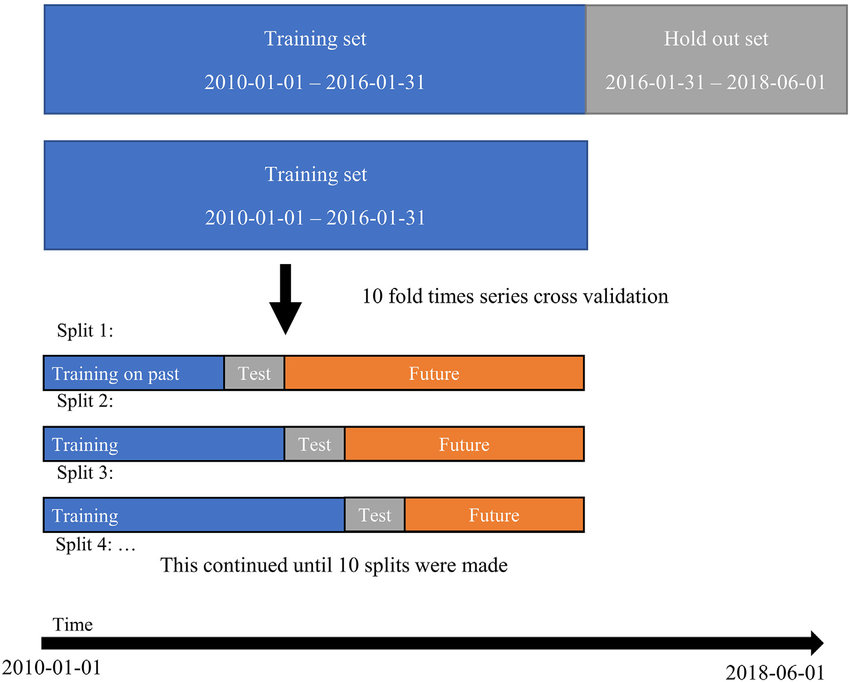

## Разбиваем данные (quantity) на train и test.

train - первые 85% данных

test - следующие 15% данных

Сколько измерений попало в тестовую часть?

In [ ]:
test_index = int(len(ts) * (1 - 0.15))

data = ts.reset_index()

X_train = data.loc[:test_index].drop(["quantity",'date'], axis=1)
y_train = data.loc[:test_index]["quantity"]
X_test = data.loc[test_index:].drop(["quantity",'date'], axis=1)
y_test = data.loc[test_index:]["quantity"]

X_train.shape, X_test.shape

((120, 6), (21, 6))

In [ ]:
X_train.head()

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6
0  311445.00 137390.00 185150.00 221952.00 225133.00 227832.00
1  157022.00 311445.00 137390.00 185150.00 221952.00 225133.00
2  251984.00 157022.00 311445.00 137390.00 185150.00 221952.00
3  662382.00 251984.00 157022.00 311445.00 137390.00 185150.00
4 1171846.00 662382.00 251984.00 157022.00 311445.00 137390.00

## Прогнозирование временных рядов

Обратите внимание, что в функции мы сами по индексу разбили датасет на обучающую и валидационную выборку для обучения моделей. Мы не можем воспользовать train_test_split, так как нам необходимо сохранять хронологию в деление выборки на части, т.е. случайное сэмплирование наблюдений нам не подойдет, в частности, т.к. мы хотим выучить тренд в данных.

0.10640616597737984


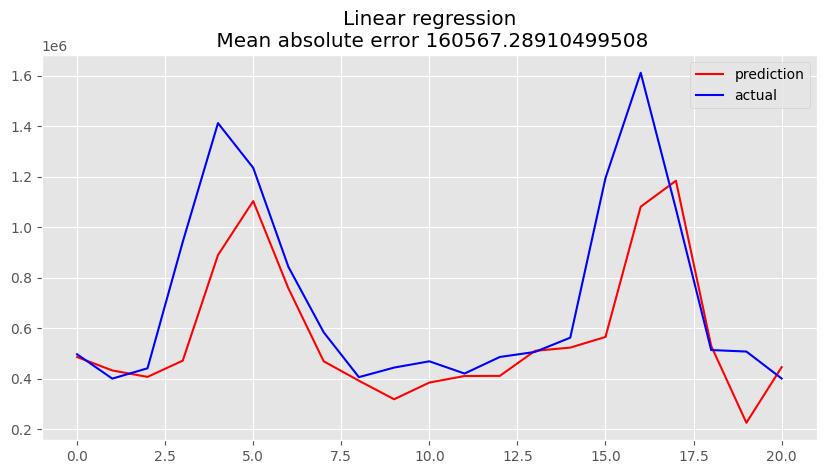

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)
r2 = r2_score(lr.predict(X_train), y_train)
print(r2)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, 'b', label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)}");

## Агрегированные признаки

Используем функцию, которая возвращает словарь, где ключами являются уникальные категории признака `cat_feature`, а значениями - средние по `real_feature`.

In [ ]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

## Улучшаем результат

Создайте колонку `month`, содержащую месяц (из даты).

Вычислите среднее значение целевой переменной по месяцам (по всем обучающим данным до разбиения на train и test).

В какой месяц года среднее количество проданного товара максимально? В ответе укажите номер месяца.

In [ ]:
data = ts

data["month"] = data.index.month

# считаем средние только по тренировочной части, чтобы избежать лика (data leak)
data["month_average"] = list(map(code_mean(data.iloc[:test_index], "month", "quantity").get, data.month))

data.loc[data["month_average"] == max(data["month_average"] ), 'month']

date
2004-10    10
2005-10    10
2006-10    10
2007-10    10
2008-10    10
2009-10    10
2010-10    10
2011-10    10
2012-10    10
2013-10    10
2014-10    10
2015-10    10
Freq: M, Name: month, dtype: int64

Далее будем использовать функцию preprocess_data.

В функции мы:

1) Разбиваем данные на тренировочную и тестовую части

2) Генерируем лаговые признаки

3) Генерируем агрегированные признаки

In [ ]:
ts = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax", "priceMod", "date"], axis=1
)

In [ ]:
index_cut = int(0.815*len(ts))

In [ ]:
def preprocess_data(data, lag_start=1, lag_end=8, index_cut=index_cut):

    data = pd.DataFrame(data.copy())

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['quantity'].shift(i)

    data = data.dropna()

    data["month"] = data.index.month

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["month_average"] = list(map(code_mean(data.iloc[:index_cut], "month", "quantity").get, data.month))

    # выкидываем закодированные средними признаки
    data.drop(["month"], axis=1, inplace=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:index_cut].drop(["quantity"], axis=1)
    y_train = data.iloc[:index_cut]["quantity"]
    X_test = data.iloc[index_cut:].drop(["quantity"], axis=1)
    y_test = data.iloc[index_cut:]["quantity"]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(ts)

X_train.shape, X_test.shape

((118, 8), (21, 8))

## Задание

Обучите линейную регрессию на подготовленных тренировочных данных и выведите $R^2$ на тесте.

Ответ округлите до сотых.

0.7439158650185


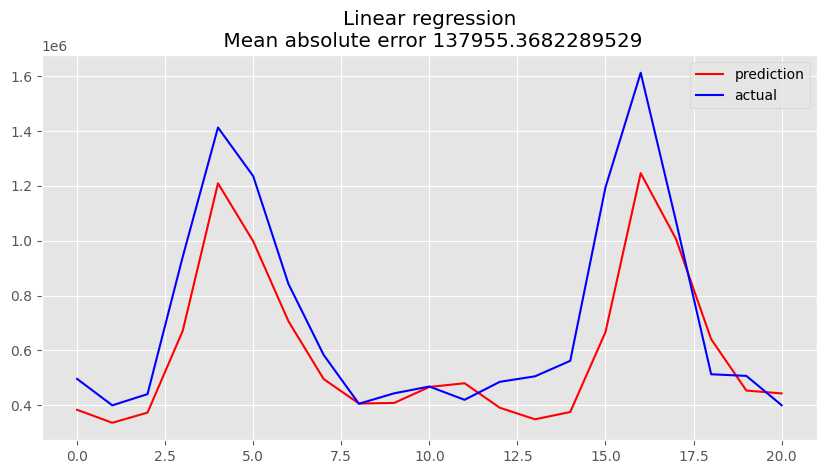

In [ ]:
# your code here

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)
#r2 = r2_score(lr.predict(X_train), y_train)
r2 = r2_score(y_test, preds)
print(r2)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, "b", label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)}");

## !  Задание 6.

Заново разбейте данные на train и test, используя `preprocess_data` с лагами от 1 до 12 не включительно.

Обучите линейную регрессию. Чему теперь равен $R^2$? Ответ округлите до сотых.

In [3]:
# your code here


# ! Задание 7. Прогноз BTC.
Проделайте следующие шаги:

* Разбейте данные на тренировочную и тестовую часть. В тест отправьте 15% данных

* Извлеките лаговые признаки

* Извлеките агрегированные признаки (средняя стоимость за день, час)

Рекомендуется использовать функцию preprocess_data с вебинара (однако, надо будет незначительно ее поменять, исходя из данных задачи).

Задайте гиперпараметры по умолчанию (в функции preprocess_data, если будете использовать ее):
* `lag_start`=5
* `lag_end`=20
* `test_size`=0.15

Можно оптимизировать параметры выше. Главное - точность прогноза.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("BTC_5min_sample.csv",
                   parse_dates=True,
                   index_col='timestamp'
                  )

data.head()

open     high      low    close  volume
timestamp                                                      
2023-06-18 00:00:00 26519.10 26542.50 26501.76 26515.80   35.45
2023-06-18 00:05:00 26508.01 26535.00 26506.13 26511.30    7.43
2023-06-18 00:10:00 26511.30 26551.00 26508.77 26519.62   18.95
2023-06-18 00:15:00 26519.44 26550.00 26464.43 26511.99   89.24
2023-06-18 00:20:00 26513.33 26541.00 26414.28 26439.52   90.02

<Axes: xlabel='timestamp'>

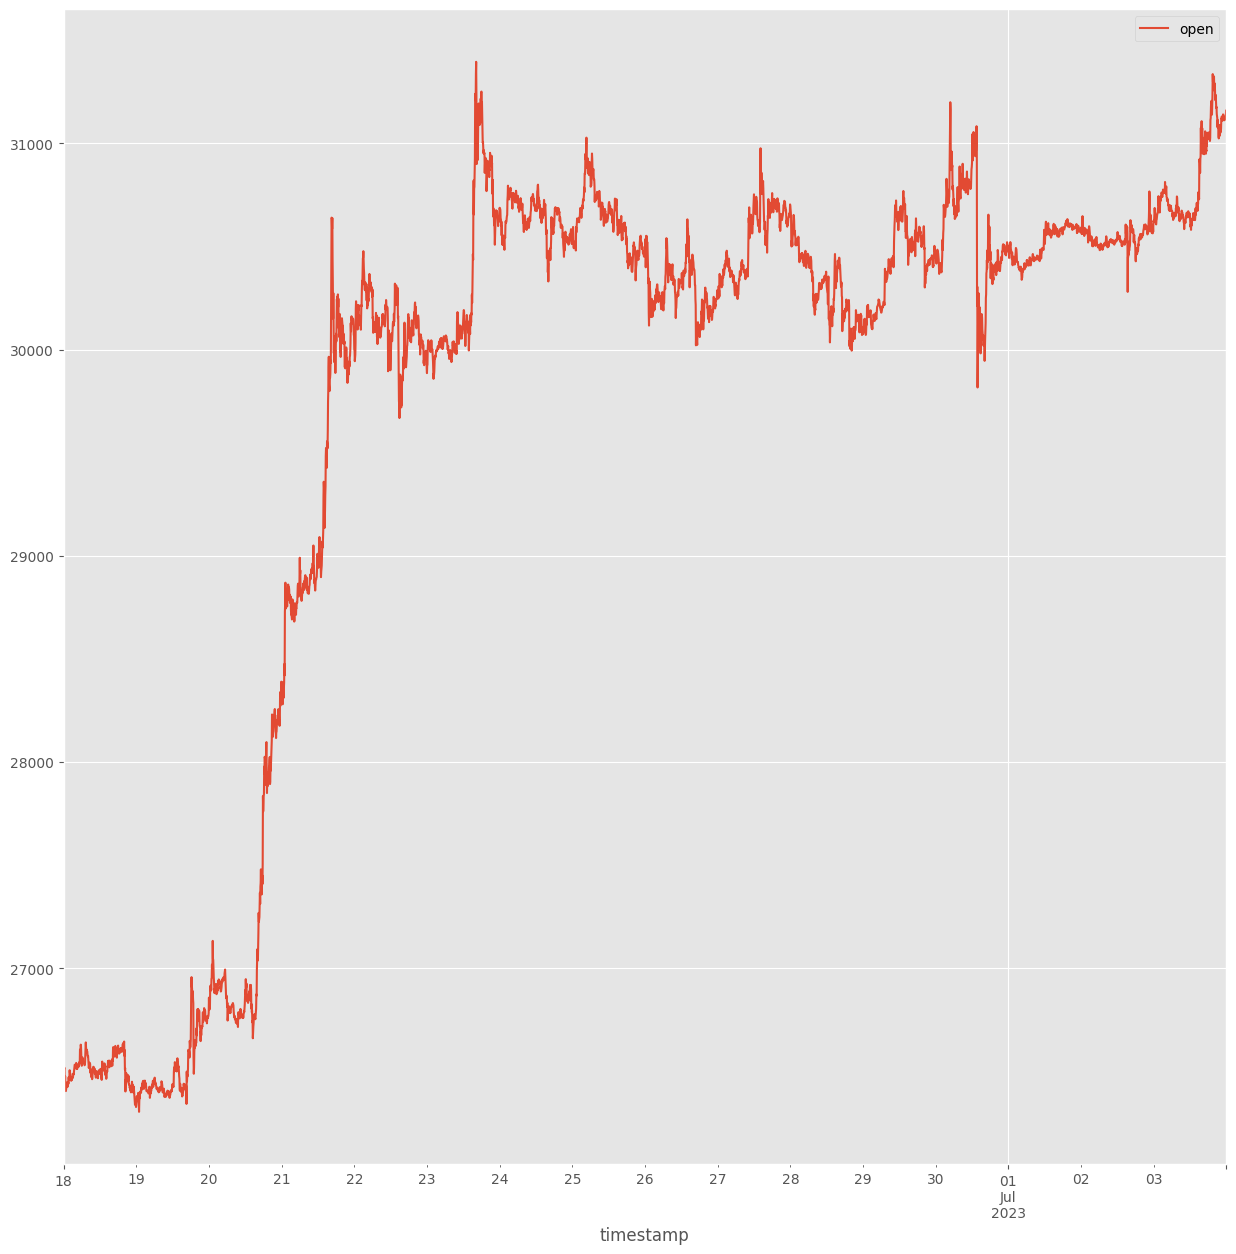

In [ ]:
data = data[['open']]

data.plot()